# Analyzing Alternative Assets Firms with Glassdoor Review Data

Introductory notes: 
* The focus here was less on traditional asset managers (mutual funds) and more on hedge funds, private equity funds, and other institutional alternative asset managers. 
* Intuition is that roles and culture are different at a Blackrock (4K reviews, 40K employees) and at Blackstone (500 reviews, 1000 employees) although both are considered behemoths in their respective spaces. 
* Several of the largest names in the space have very few glassdoor reviews, ie: Tiger Global Viking Global Farallon HPS Partners 
* Full list of firms [here](https://www.peregrinecommunications.com/hubfs/Reports/Alts-50-Report-2021-Peregrine-Communications.pdf)

# Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import requests
import time
import math
import re
import pickle
import itertools
import glob
import string

import contractions

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *

from gsdmm import MovieGroupProcess

from textblob import TextBlob

import gensim 
import gensim.downloader as gensim_api
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

# from tensorflow.keras import models, layers, preprocessing as kprocessing

from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyLDAvis import gensim_models
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

In [5]:
sns.set_style('darkgrid')
sns.set_palette("winter_r")

# Data
* Glassdoor Reviews: Top Alternative Asset Managers 
* Reviews were scraped using this [tool](https://github.com/timpanon/glassdoor_nlp_alternatives/glassdoor_review_scraper.ipnyb)

### Analysis
* What are the top companies doing really well? 
* From an employee standpoint, why are these the top companies? What matters to employees the most? 
* What are the companies performing poorly doing wrong? From an employee standpoint, why are these companies failing? 
* Are different types of employees feeling more or less valued? (analyze by position) 
* Topic Modeling 

## Load Files 

In [6]:
"""
Takes in a list of csv files using glob 
Output: dataframe combining all csvs vertically (axis=0)
Assumes all csvs have same column names 
"""
def files_to_df(glob_csv):
    final_df = pd.DataFrame()
    
    for file in glob_csv:
        company_name = file.split('\\')[1].split('.')[0] # get the company name from the file 
        try:
            df = pd.read_csv(file)
        except:
            df = pd.read_csv(file, encoding='latin1')
        
        # drop the extra index column 
        df = df.drop(df.columns[0], axis=1)
        
        #check if there's a company column, if not, add company name to all rows  
        if pd.isnull(df.iloc[0].company):
            df.company = company_name
        
        final_df = pd.concat([final_df, df])
        
    return final_df

In [7]:
""" 
Load all csv files from folders 
drop each group into a dataframe 

"""
csvfiles = glob.glob('reviews/investment/' + '*.csv')
investment_reviews_raw =  files_to_df(csvfiles)

In [8]:
print(investment_reviews_raw.isna().sum())
print(len(investment_reviews_raw))
print(investment_reviews_raw.company.unique())

company              0
headline            20
date                 0
overall_rating       0
author_position    920
pros                 0
cons                 0
dtype: int64
8512
['Acadian' 'Advent' 'American Capital' 'Angelo Gordon'
 'Apollo Global Management' 'AQR Capital Management' 'Ares Management'
 'Bain Capital' 'Balyasny Asset Management' 'Bayview Asset Management'
 'Bessemer Trust Company' 'Boston Private' 'Bridgewater'
 'Brookfield Asset Management' 'Cerberus' 'Citadel' 'CPP Investments'
 'CVC' 'DE Shaw' 'Fortress Investment Group' 'Geller & Company'
 'HarbourVest Partners, LLC' 'Intellectual Ventures' 'Jane Street'
 'Janus Capital' 'Jump Trading' 'KKR' 'Lord Abbett & Co.' 'Man Group'
 'Millennium' 'Moelis & Company' 'Neuberger Berman' 'Neuberger'
 'Oaktree Capital Management' 'Oppenheimer Holdings' 'PIMCO'
 'PineBridge Investments' 'Point72' 'Putnam Investments'
 'Sculptor Capital' 'Sequoia' 'Silver Lake' 'SoftBank' 'Techstars'
 'The Blackstone Group' 'The Carlyle Group' 'TP

# I. EDA 

1. [Define Methods](#eda_define_methods)
2. [Prep Data](#eda_prep_data)
3. [Overall Time Trends](#eda_overall_time)
4. [Other Questions](#eda_other_questions)
    * Who are the top firms? 
    * Are there similarities between these companies and the GD top companies? 
    * For the companies that are not doing well, what are the reasons? 
    * Are different types of employees feeling more or less valued? (analyze by position) 
    * Which companies are on an upward trend? 
    * Can we predict the rating based on the review? 

<a id='eda_define_methods'></a>
## 1. Define Methods

In [9]:
def position_level(position):
    executive_pattern = re.compile("[Cc]\w[Oo]")
    sr_manager_pattern = re.compile("(senior)\s(\w*)\s(manager)")
    if executive_pattern.match(position.lower()) or sr_manager_pattern.match(position.lower()):
        return "senior"
    
    senior = ["director", "chief", "executive", "senior manager", "head", "general manager", "leader", "president", "vp"]
    for pos in senior:
        if pos in position.lower():
            return "senior"
    
    return "other"


def position_department(position):
    try: 
        marketing_sales = ["marketing", "sales", "account manager","business development", "investor relations", "IR", "client",'customer']
        for pos in marketing_sales:
            if pos in position.lower():
                return "marketing_sales"

        hr = ["human", "hr", "recruit", "talent", "l&d", "learning", "people", "culture", "diversity", "inclusion"]
        for pos in hr:
            if pos in position.lower():
                return "hr_admin_legal"

        finance = ["accounting", 'operations', "valuation", "controller", "accountant", "finance", "payable", "receivable", "financial", "financial analyst", "fp"]
        for pos in finance:
            if pos in position.lower():
                return "accounting_finance_ops"

        tech = ["engineer", "data", "software", "ux", "ui", "experience", "developer", "product", "tech", "programmer", "it ", "information", "solution"]
        for pos in tech:
            if pos in position.lower():
                return "technology"
        
        investment = ["investment", "risk", "quantitative", "quant", "analyst", "trading", "trader", "investor", "front office", "portfolio", "pm"]
        for pos in investment:
            if pos in position.lower():
                return "investment"
        
        admin = ['assistant', 'administrative','receptionist', 'front desk','facilities']
        for pos in admin:
            if pos in position.lower():
                return "hr_admin_legal"
            
        legal = ['legal', 'attorney','legal', 'compliance']
        for pos in legal:
            if pos in position.lower():
                return "hr_admin_legal"
            
        intern = ['intern','student','summer']
        for pos in intern:
            if pos in position.lower():
                return "intern"
            
    except:
        print(position)
    
    return "other"

def fill_missing_values(df):
    position_missing = df.author_position.isna().sum()
    headline_missing = df.headline.isna().sum()
    print(df.isna().sum())
#     print(f"There are {position_missing} missing position records.")
#     print(f"There are {headline_missing} missing headline records.")
    
    df.author_position = df.author_position.fillna("unknown")
    df.headline = df.headline.fillna('')
    df.pros = df.pros.fillna('')
#     print('After filling missing values: ')
#     print(df.isna().sum())

    return df 

# 
def create_position_cols(df):
    df['position_department'] = df.author_position.apply(lambda x: position_department(x))
    df['position_level'] = df.author_position.apply(lambda x: position_level(x))
    return df 

# convert date column to datetime 
def convert_datetime(df):
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    return df

# Add mean rating column 
def add_mean_rating(df):
    reviews_by_rating = df.groupby('company').overall_rating.mean().reset_index().rename(columns={'overall_rating':'mean_rating'})
    rating_dict = reviews_by_rating.set_index('company').to_dict()['mean_rating']
    df['mean_rating'] = df.company.apply(lambda x: float(rating_dict[x]))
    return df

# add review count column 
def add_review_count(df):
    reviews_count = df.groupby('company').headline.count().reset_index().rename(columns={'headline':'count'})
    count_dict = reviews_count.set_index('company').to_dict()['count']
    df['review_count'] = df.company.apply(lambda x: int(count_dict[x]))
    return df

# requires review_count column 
def remove_reviews(df, count=50):
    if 'review_count' not in df.columns:
        print('No review count column.')
        return df
    else:
        company_count = df.groupby('company').review_count.mean().reset_index()
        print(f'\nRemoving following companies with less than {count} reviews:')
        print(list(company_count[company_count.review_count < count].company))
        return df[df.review_count >= count]
    

In [10]:
"""
visualize distribution of reviews by year.
input requires a 'date' and a headline column in datetime format
plots barplot 
"""

def reviews_by_year(df, display=True):
    temp_df = df.copy()
    temp_df['year'] = temp_df.date.apply(lambda x: x.year)
    count_year = temp_df.groupby('year').company.count().reset_index()
    count_year['count_normalized'] = round(((count_year['company'] / count_year['company'].sum()) * 100),2)
    plt.figure(figsize=(12,6))
    sns.barplot(x = count_year.year, y=count_year.company, palette='winter')
    plt.ylabel('Number of Reviews')
    plt.xlabel('Year')
    plt.show()
    if display:
        print(count_year[['year','count_normalized']])

def reviews_by_month(df, display=True):
    temp_df = df.copy()
    temp_df['month'] = temp_df.date.apply(lambda x: x.month)
    count_month = temp_df.groupby('month').company.count().reset_index()
    count_month['count_normalized'] = round(((count_month['company'] / count_month['company'].sum()) * 100),2)
    plt.figure(figsize=(12,6))
    sns.barplot(x = count_month.month, y=count_month.company, palette='winter')
    plt.ylabel('Number of Reviews')
    plt.xlabel('Month')
    plt.show()
    if display:
        print(count_month[['month','count_normalized']])

In [11]:
""" 
For seeing trends for multiple companies 
Plot average yearly rating of a list of companies on one plot 
input: df of companies with ratings, number of colums for plot (optional), figure size for plot (optional)
output: group of subplots with line charts visualizing yearly overall rating of companies 
"""
def plot_company_rankings_yearly(df, num_cols=4, figsize=(25,15)):
    # get the list of companies and number of plots 
    company_lst = df.company.unique()
    total_subplots = len(company_lst) 
    cols = num_cols 
    rows = total_subplots // cols
    if total_subplots % cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {cols}, Total rows: {rows}")
    
    # set index to 0, index is used for iterating through the company list 
    index=0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize) 
    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            # delete plots that are not going to be used 
            if index >= total_subplots:
                fig.delaxes(axes[row,col])
                index+=1
            else: 
                ax = axes[row,col] 
                # get company df for plotting 
                company_name = company_lst[index] 
                company_df = df[df.company==company_name]
                company_df['year'] = company_df.date.apply(lambda x: x.year)
                rating_per_year = company_df.groupby('year').overall_rating.mean().reset_index()
                # plot the company on the right ax 
                rating_per_year.plot(x='year',y='overall_rating',ax=ax)
                ax.set_title(f'{company_name} ratings')
                ax.set_xticks(rating_per_year.year)
                ax.set_xticklabels(rating_per_year.year)
    #             ax.axis('off')
                index += 1

    plt.tight_layout()


""" 
For zooming in on one company 
Plot average yearly rating of a single company
output: line chart 
"""
def plot_ranking_yearly(df, company):
    company_df = df[df.company==company]
    company_df['year'] = company_df.date.apply(lambda x: x.year)
    rating_per_year = company_df.groupby('year').overall_rating.mean().reset_index()
    
    fig, ax = plt.subplots(figsize=(12,6))
    rating_per_year.plot(x='year',y='overall_rating',ax=ax)
    ax.set_title(f'{company} ratings')
    ax.set_xticks(rating_per_year.year)
    ax.set_xticklabels(rating_per_year.year)
    
    plt.show()

In [12]:
""" 
For seeing trends for multiple companies and zooming in during the pandemic 
Plot average monthly rating of a list of companies on one plot 
input: df of companies with ratings, number of colums for plot (optional), figure size for plot (optional)
output: group of subplots with line charts visualizing yearly overall rating of companies 
"""
def plot_company_rankings_pandemic(df, company_lst, num_cols=4, figsize=(25,15)):
    # get the list of companies and number of plots 
    total_subplots = len(company_lst) 
    rows = total_subplots // num_cols

    if total_subplots % num_cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {num_cols}, Total rows: {rows}")

    # set index to 0, index is used for iterating through the company list 
    index=0
    fig, axes = plt.subplots(nrows=rows, ncols=num_cols, figsize=(48,6)) 
    # if there are more than 1 row 
    if axes.size > num_cols:
        for row in range(axes.shape[0]):
            for col in range(axes.shape[1]):
                # delete plots that are not going to be used 
                if index >= total_subplots:
                    fig.delaxes(axes[row,col])
                    index+=1
                else: 
                    ax = axes[row,col] 
                    # get company df for plotting 
                    company_name = company_lst[index] 
                    company_df = df[df.company==company_name]
                    company_df['mon_year'] = company_df.date.dt.to_period('M')
                    rating_per_year = company_df.groupby('mon_year').overall_rating.mean()
                    # plot the company on the right ax 
                    rating_per_year['2020':].plot(x='year',y='overall_rating',ax=ax)
                    ax.set_title(f'{company_name} ratings')
                    #                 ax.set_xticks(rating_per_year['2020':].index)
                    #                 ax.set_xticklabels(rating_per_year['2020':].index, rotation=30)
                    #             ax.axis('off')
                    index += 1
     # if there's only 1 row 
    else:
        for col in range(axes.shape[0]):
            if index >= total_subplots:
                fig.delaxes(axes[row])
                index += 1
            else:
                ax = axes[row] 
                # get company df for plotting 
                company_name = company_lst[index] 
                company_df = df[df.company==company_name]
                company_df['mon_year'] = company_df.date.dt.to_period('M')
                rating_per_year = company_df.groupby('mon_year').overall_rating.mean()
                # plot the company on the right ax 
                rating_per_year['2020':].plot(x='year',y='overall_rating',ax=ax)
                ax.set_title(f'{company_name} ratings')
                index += 1

    plt.tight_layout()

def plot_ranking_pandemic(df, company):
    company_df = df[df.company==company]
    company_df['mon_year'] = company_df.date.dt.to_period('M')
    rating_per_year = company_df.groupby('mon_year').overall_rating.mean()
    fig, ax = plt.subplots(figsize=(12,6))
    ts = rating_per_year['2020':]
    ts = ts.resample('M').bfill()
    ts.plot(x='mon_year',y='overall_rating',ax=ax)
    ax.set_title(f'{company} ratings')
    ax.set_xticks(ts.index)
    ax.set_xticklabels(ts.index, rotation=30)
    plt.show()

<a id='eda_prep_data'></a>
## 2. Prep Data

In [13]:
# Cleaning and new columns 
reviews = convert_datetime(investment_reviews_raw)
reviews = reviews[reviews.date > '2011-12-31']  # only reviews in the past 10 years 
reviews = fill_missing_values(reviews)
reviews = create_position_cols(reviews) # create column for author position 

# print(f'There are {len(reviews[reviews.pros.apply(lambda x: pd.isnull(x))])} reviews with no text in the pros column.')
reviews = add_mean_rating(reviews)
reviews = add_review_count(reviews) 

company              0
headline            20
date                 0
overall_rating       0
author_position    861
pros                 0
cons                 0
dtype: int64


In [11]:
print(len(reviews))

8422


In [12]:
reviews.head()

company                                           headline       date  \
0  Acadian                                    work experience 2022-03-13   
1  Acadian                    A Case Study in Poor Leadership 2022-03-10   
2  Acadian                                  Overall very good 2022-03-10   
3  Acadian         Great firm,  nice to be back in the office 2022-03-02   
4  Acadian  Good work life balance. Opportunities to contr... 2022-02-17   

   overall_rating          author_position  \
0             3.0        Trading Developer   
1             1.0       Anonymous Employee   
2             4.0       Anonymous Employee   
3             5.0       Anonymous Employee   
4             5.0  Investment Data Analyst   

                                                pros  \
0   good small team management and agile environment   
1  There is no shortage of work at Acadian, you w...   
2            Great benefits and a lot of good people   
3  Great firm, nice comp package (health and educ...   
4  Environment is relaxed. Will have time to comp...   

                                                cons position_department  \
0  Excessive team fragmentation recently caused e...          technology   
1  Acadian’s culture was very disappointing. For ...               other   
2                           Nothing much to speak of               other   
3  Took a while to get back to the office after C...               other   
4  Satellite office so coordination with HQ in Bo...          technology   

  position_level  mean_rating  review_count  
0          other          3.9            50  
1          other          3.9            50  
2          other          3.9            50  
3          other          3.9            50  
4          other          3.9            50

<a id='eda_overall_time'></a>
## 3. Overall review time trends

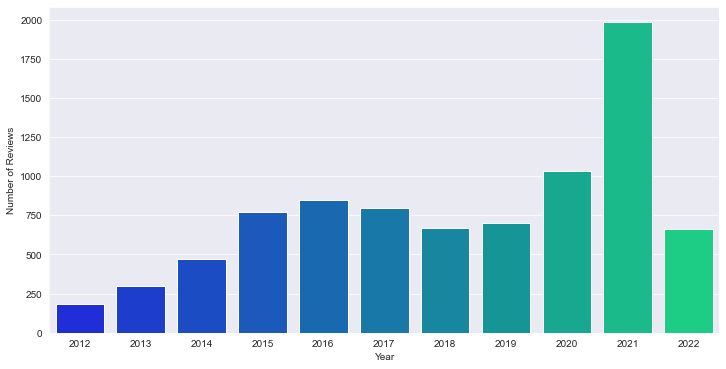

    year  count_normalized
0   2012              2.20
1   2013              3.54
2   2014              5.57
3   2015              9.18
4   2016             10.09
5   2017              9.46
6   2018              7.97
7   2019              8.30
8   2020             12.27
9   2021             23.55
10  2022              7.88


In [89]:
reviews_by_year(reviews)

### Reviews per year + quits

Plot data about the number of employees who quit their jobs from [BLS](https://data.bls.gov/cgi-bin/surveymost), against the number of glassdoor reviews per year. 

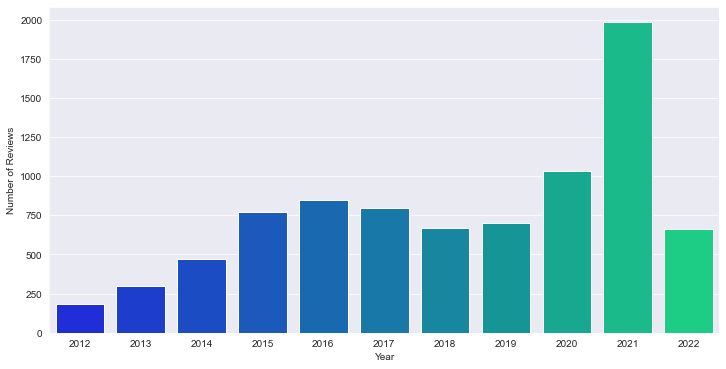

In [90]:
temp_df = reviews.copy()
temp_df['year'] = temp_df.date.apply(lambda x: x.year)
count_year = temp_df.groupby('year').company.count().reset_index()
count_year['count_normalized'] = round(((count_year['company'] / count_year['company'].sum()) * 100),2)
plt.figure(figsize=(12,6))
sns.barplot(x = count_year.year, y=count_year.company, palette='winter')
plt.ylabel('Number of Reviews')
plt.xlabel('Year')
plt.show()

In [20]:
quits = pd.read_csv('quits.csv')
quits = quits[:-1]
quits = quits.fillna(0)
quits = quits.astype(int)
quits.set_index('Year', inplace=True)
stacked = quits.stack()

In [93]:
quits_dict = {}
for row in quits.iterrows():
    year = row[0]
    months = row[1].index.values
    values = row[1].values
    for i in range(len(months)):
        month = months[i]
        value = values[i]
        date = f'{month}-{year}'
        quits_dict[date] = value
quits_dict

{'Jan-2012': 2030,
 'Feb-2012': 2130,
 'Mar-2012': 2167,
 'Apr-2012': 2134,
 'May-2012': 2138,
 'Jun-2012': 2152,
 'Jul-2012': 2072,
 'Aug-2012': 2069,
 'Sep-2012': 1950,
 'Oct-2012': 2035,
 'Nov-2012': 2078,
 'Dec-2012': 2051,
 'Jan-2013': 2280,
 'Feb-2013': 2298,
 'Mar-2013': 2124,
 'Apr-2013': 2296,
 'May-2013': 2234,
 'Jun-2013': 2203,
 'Jul-2013': 2363,
 'Aug-2013': 2316,
 'Sep-2013': 2302,
 'Oct-2013': 2372,
 'Nov-2013': 2391,
 'Dec-2013': 2287,
 'Jan-2014': 2311,
 'Feb-2014': 2411,
 'Mar-2014': 2449,
 'Apr-2014': 2474,
 'May-2014': 2483,
 'Jun-2014': 2507,
 'Jul-2014': 2633,
 'Aug-2014': 2549,
 'Sep-2014': 2732,
 'Oct-2014': 2718,
 'Nov-2014': 2600,
 'Dec-2014': 2552,
 'Jan-2015': 2764,
 'Feb-2015': 2741,
 'Mar-2015': 2754,
 'Apr-2015': 2705,
 'May-2015': 2743,
 'Jun-2015': 2756,
 'Jul-2015': 2764,
 'Aug-2015': 2879,
 'Sep-2015': 2778,
 'Oct-2015': 2810,
 'Nov-2015': 2897,
 'Dec-2015': 3056,
 'Jan-2016': 2875,
 'Feb-2016': 2994,
 'Mar-2016': 2917,
 'Apr-2016': 2955,
 'May-2016':

In [94]:
final = pd.DataFrame.from_dict(quits_dict.items()).rename(columns={0:'date',1:'quits'})
final.date = pd.to_datetime(final.date)

In [96]:
final['year'] = final.date.apply(lambda x: x.year)
quits_per_year = final.groupby('year').quits.sum().reset_index()
combined = count_year.merge(quits_per_year, on='year', how='inner')

combined_scaled = combined.copy()
combined_scaled['reviews'] = (combined.company - combined.company.min()) / (combined.company.max() - combined.company.min())
combined_scaled['quits'] = (combined.quits - combined.quits.min()) / (combined.quits.max() - combined.quits.min())
combined_scaled

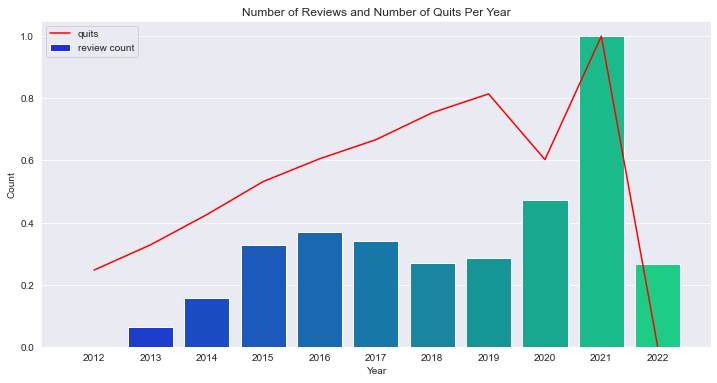

In [99]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x = combined_scaled.year, y=combined_scaled.reviews, palette='winter', ax=ax, label='review count')
# ax2 = ax.twinx()
sns.lineplot(data=combined_scaled, x=ax.get_xticks(), y="quits", ax=ax, color='r', label='quits')
plt.title('Number of Reviews and Number of Quits Per Year')
plt.ylabel('Count')
plt.xlabel('Year')
plt.show()

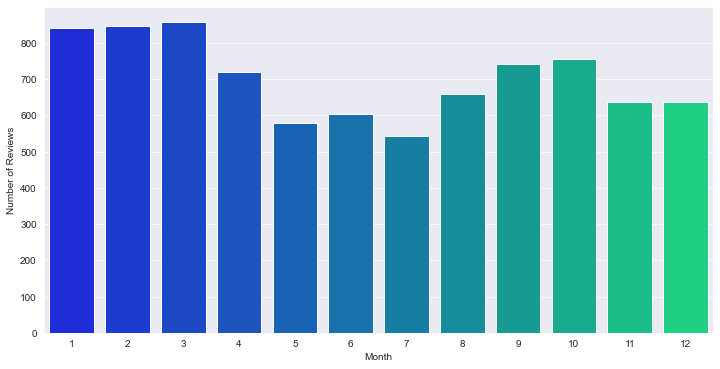

    month  count_normalized
0       1             10.00
1       2             10.06
2       3             10.18
3       4              8.54
4       5              6.87
5       6              7.18
6       7              6.45
7       8              7.81
8       9              8.81
9      10              8.96
10     11              7.56
11     12              7.58


In [100]:
reviews_by_month(reviews)

* Reviews spiked in 2021
* ~2X as many reviews in 2021 than in 2020 
* More reviews in Q1 than in other times of the year 

<a id='eda_other_questions'></a>
## 4. Other Questions
* [Who are the top firms?](#eda_top_firms)
* [Are there any differences in rankings since pandemic?](#eda_rankings_pandemic)
* [How have companies been rated over time?](#eda_companies_time)
* [How have these companies done during the pandemic?](#eda_companies_pandemic)
* [Are different types of employees feeling more or less valued?](#eda_value)

<a id='eda_top_firms'></a>
### Who are the top firms?

In [24]:
# what are the average ratings per company? 
review_rankings = reviews.groupby('company').mean_rating.mean().reset_index().sort_values(by='mean_rating', ascending=False)

# how many reviews per company? 
review_counts = reviews.groupby('company').review_count.mean().reset_index().sort_values(by='review_count',ascending=True)
review_counts.review_count = review_counts.review_count.apply(lambda x: int(x))

# merge together
company_rankings = review_rankings.merge(review_counts, left_on='company', right_on='company')

# remove companies with less than 100 reviews
company_rankings = remove_reviews(company_rankings,count=100)
top_25_list = list(company_rankings[:25].company)



Removing following companies with less than 100 reviews:
['Acadian', 'Advent', 'American Capital', 'Angelo Gordon', 'Balyasny Asset Management', 'CVC', 'Cerberus', 'HarbourVest Partners, LLC', 'Sculptor Capital', 'Silver Lake', 'Warburg Pincus']


In [25]:
top_25 = company_rankings[:25][['company','mean_rating']]
top_25 = top_25.style.set_caption("Avg GD Ratings (2012-Present)").hide_index()
top_25

<a id='eda_rankings_pandemic'></a>
### Are there any differences in rankings since pandemic? 

In [26]:
# create df for recent reviews 
recent_reviews = reviews[reviews.date > '2020-03-01'] 

# what are the average ratings per company? 
review_rankings_pandemic = recent_reviews.groupby('company').overall_rating.mean().reset_index().rename(columns={'overall_rating':'mean_rating'}).sort_values(by='mean_rating', ascending=False)

# how many reviews per company? 
review_counts_pandemic = recent_reviews.groupby('company').review_count.count().reset_index().sort_values(by='review_count',ascending=True)

# merge together
company_rankings_pandemic = review_rankings_pandemic.merge(review_counts_pandemic, left_on='company', right_on='company')

# remove companies with less than 100 reviews
# company_rankings_pandemic = remove_reviews(company_rankings_pandemic,count=40)
top_pandemic = company_rankings_pandemic[company_rankings_pandemic.company.apply(lambda x: x in top_25_list)][['company','mean_rating']]
top_pandemic = top_pandemic.style.set_caption("Avg GD Ratings Since Pandemic").hide_index()
top_pandemic

Interpretation: There doesn't appear to be any differences since the pandemic with overall rankings 

In [30]:
# at least 50 reviews 
top_companies = ['DE Shaw','Bain Capital','Jane Street', 'KKR', 'Two Sigma'] 
low_companies = ['Apollo Global Management','SoftBank','Citadel','Brookfield Asset Management','Oppenheimer Holdings']

#### Comparison with Tech (Fang) 

In [99]:
facebook_reviews = pd.read_csv('reviews/top_large/Meta.csv')
apple_reviews = pd.read_csv('reviews/top_large/Apple.csv')
netflix_reviews = pd.read_csv('reviews/internet_large/Netflix.csv')
google_reviews = pd.read_csv('reviews/top_large/Google.csv')

fang_reviews = pd.concat([facebook_reviews, apple_reviews, netflix_reviews, google_reviews])
fang_reviews = convert_datetime(fang_reviews)

In [103]:
google_reviews.date.min()

'2020-08-21'

In [100]:
review_rankings_fang = fang_reviews.groupby('company').overall_rating.mean().reset_index().rename(columns={'overall_rating':'mean_rating'}).sort_values(by='mean_rating', ascending=False)
review_rankings_fang = review_rankings_fang.style.set_caption("FANG Average GD Ratings").hide_index()
review_rankings_fang

In [101]:
recent_reviews_fang = fang_reviews[fang_reviews.date > '2020-03-01'] 
pandemic_fang = recent_reviews_fang.groupby('company').overall_rating.mean().reset_index().rename(columns={'overall_rating':'mean_rating'}).sort_values(by='mean_rating', ascending=False)
pandemic_fang = pandemic_fang.style.set_caption("FANG Average GD Ratings (2020 - Present)").hide_index()
pandemic_fang

<a id='eda_companies_time'></a>
### How have companies been rated over time? 
* For the past 10 years, what do the trends look like? 
* How have companies done in the pandemic? 

In [104]:
reviews.company.unique()

array(['Acadian', 'Advent', 'American Capital', 'Angelo Gordon',
       'Apollo Global Management', 'AQR Capital Management',
       'Ares Management', 'Bain Capital', 'Balyasny Asset Management',
       'Bayview Asset Management', 'Bessemer Trust Company',
       'Boston Private', 'Bridgewater', 'Brookfield Asset Management',
       'Cerberus', 'Citadel', 'CPP Investments', 'CVC', 'DE Shaw',
       'Fortress Investment Group', 'Geller & Company',
       'HarbourVest Partners, LLC', 'Intellectual Ventures',
       'Jane Street', 'Janus Capital', 'Jump Trading', 'KKR',
       'Lord Abbett & Co.', 'Man Group', 'Millennium', 'Moelis & Company',
       'Neuberger Berman', 'Neuberger', 'Oaktree Capital Management',
       'Oppenheimer Holdings', 'PIMCO', 'PineBridge Investments',
       'Point72', 'Putnam Investments', 'Sculptor Capital', 'Sequoia',
       'Silver Lake', 'SoftBank', 'Techstars', 'The Blackstone Group',
       'The Carlyle Group', 'TPG', 'Two Sigma', 'Warburg Pincus'],
     

Total plots: 49, Total cols: 4, Total rows: 13


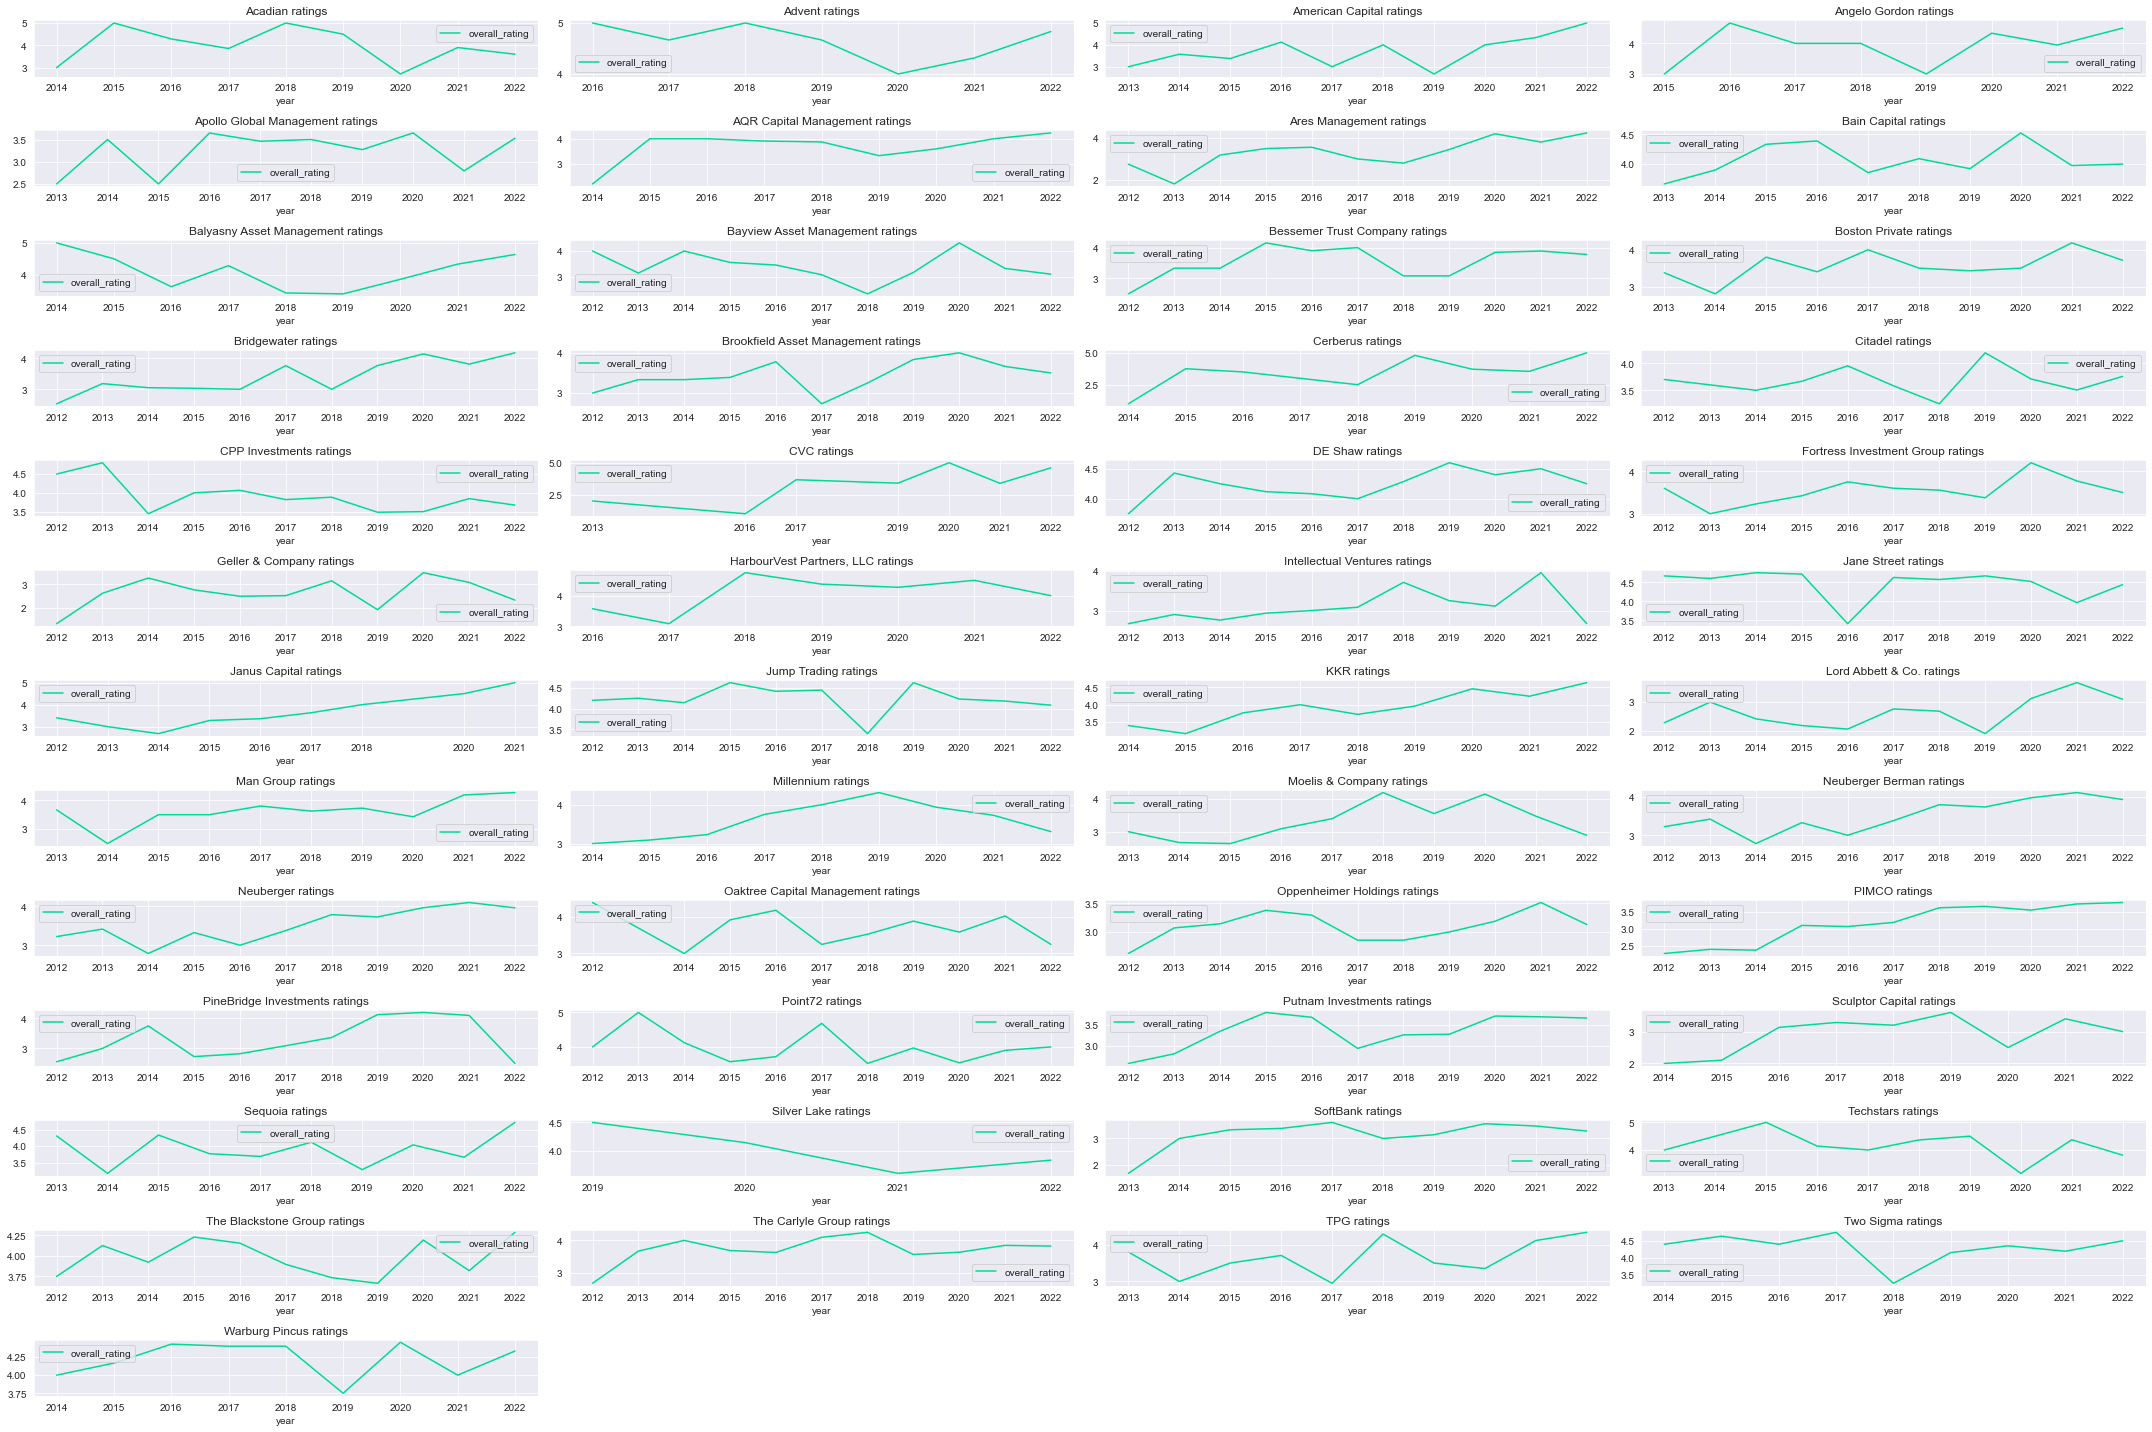

In [106]:
plot_company_rankings_yearly(reviews, figsize=(30,20))

These companies look like they are trending in a negative direction, especially since the pandemic:
* Intellectual Ventures 
* Lord Abbett 
* Fortress
* Brookfield 
* Moelis 

These companies look like they are trending in a positive direction, especially since the pandemic:
* Jane Street
* Ares Management  
* KKR 
* Warburg Pincus 
* Citadel 

Further investigation to follow in coming steps. 

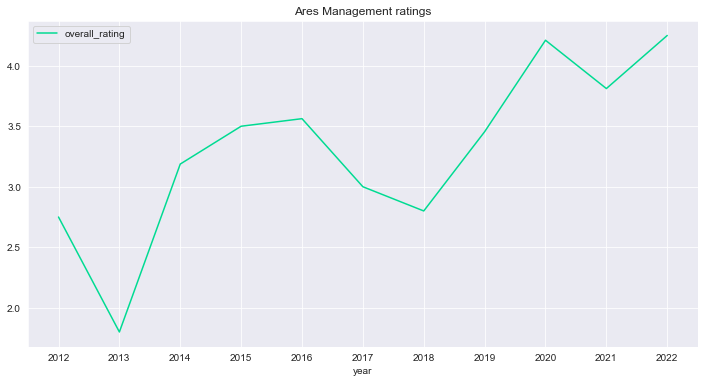

In [107]:
plot_ranking_yearly(reviews, 'Ares Management')

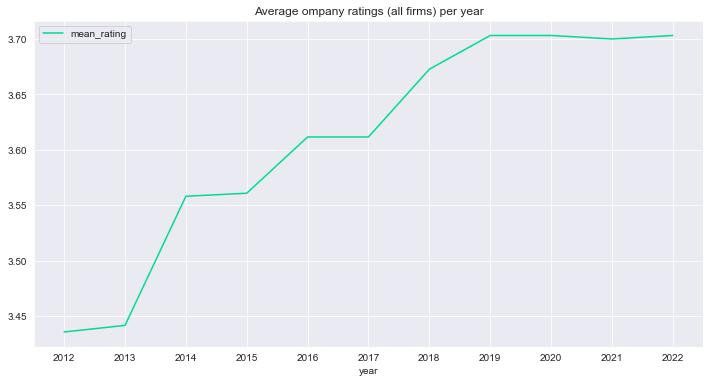

In [70]:
all_company_df = reviews.copy()
all_company_df['year'] = all_company_df.date.apply(lambda x: x.year)
rating_per_year = all_company_df.groupby('year').mean_rating.median().reset_index()
fig, ax = plt.subplots(figsize=(12,6))
rating_per_year.plot(x='year',y='mean_rating',ax=ax)
ax.set_title(f'Average ompany ratings (all firms) per year')
ax.set_xticks(rating_per_year.year)
ax.set_xticklabels(rating_per_year.year)
plt.show()

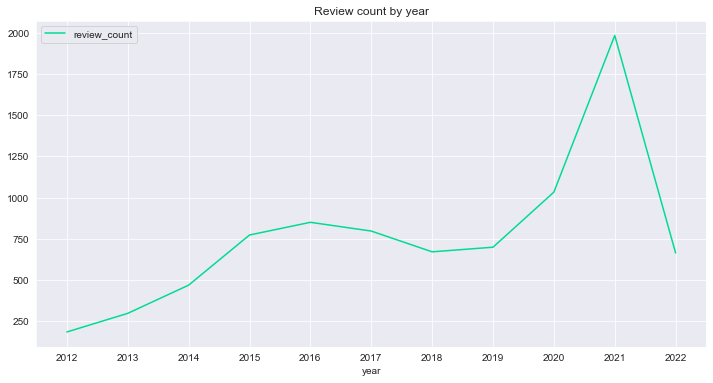

In [68]:
all_company_df = reviews.copy()
all_company_df['year'] = all_company_df.date.apply(lambda x: x.year)
rating_per_year = all_company_df.groupby('year').company.count().reset_index().rename(columns={'company':'review_count'})
fig, ax = plt.subplots(figsize=(12,6))
rating_per_year.plot(x='year',y='review_count',ax=ax)
ax.set_title(f'Review count by year')
ax.set_xticks(rating_per_year.year)
ax.set_xticklabels(rating_per_year.year)
plt.show()

<a id='eda_companies_pandemic'></a>
### How have these companies done during the pandemic? 

These companies look like they are trending in a negative direction, especially since the pandemic:
* Intellectual Ventures 
* Lord Abbett 
* Fortress
* Brookfield 
* Moelis 

These companies look like they are trending in a positive direction, especially since the pandemic:
* Jane Street
* Ares Management  
* KKR 
* Warburg Pincus 
* Citadel 

Total plots: 5, Total cols: 4, Total rows: 2


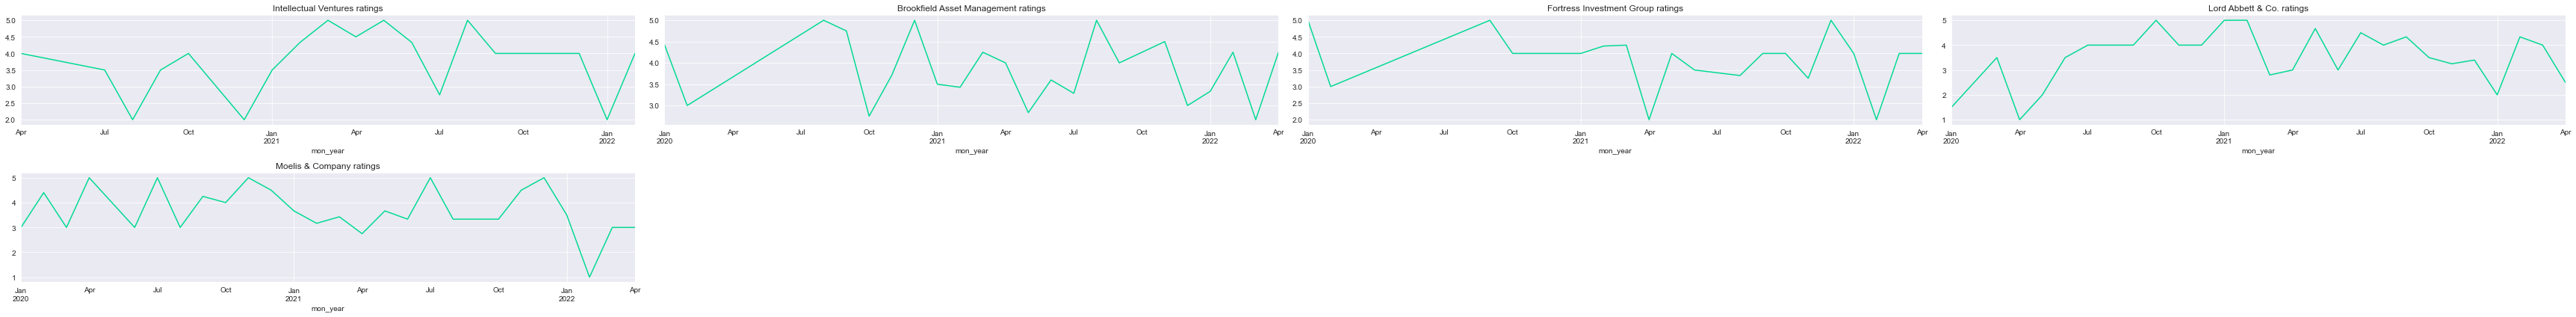

In [109]:
negative_trending_companies = ['Intellectual Ventures', 'Brookfield Asset Management', 'Fortress Investment Group', 'Lord Abbett & Co.','Moelis & Company']
positive_trending_companies = ['Jane Street','Ares Management','KKR','Warburg Pincus', 'Citadel']
plot_company_rankings_pandemic(reviews, negative_trending_companies)

In [110]:
# fig, ax = plt.subplots(figsize=(18,6)) 
# for company in company_lst:
#     # get company reviews for plotting 
#     company_data = reviews[reviews.company==company]
#     company_data['mon_year'] = company_data.date.dt.to_period('M')
#     rating_per_year = company_data.groupby('mon_year').overall_rating.mean()
#     # plot the company on the right ax 
#     rating_per_year['2020':].plot(x='mon_year',y='overall_rating',ax=ax, label=f'{company}')
#     plt.title('Company ratings per year')
# #     ax.set_xticks(rating_per_year.year)
# #     ax.set_xticklabels(rating_per_year.year)
# plt.legend()
# plt.show()

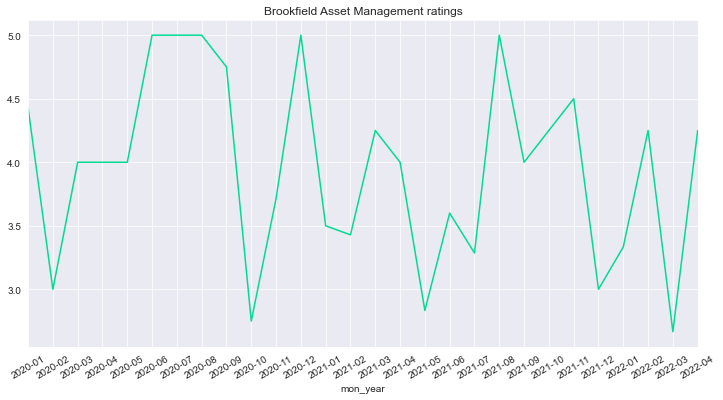

In [111]:
plot_ranking_pandemic(reviews, 'Brookfield Asset Management')

<a id='eda_value'></a>
###  Are different types of employees feeling more or less valued? (analyze by position) 

In [113]:
rating_by_dept = reviews.groupby('position_department').overall_rating.mean().reset_index().sort_values(by='overall_rating', ascending=False)
count_by_dept = reviews.groupby('position_department').pros.count().reset_index().rename(columns={'pros':'count'})
rating_by_dept.merge(count_by_dept, left_on='position_department', right_on='position_department')

position_department  overall_rating  count
0                  intern        4.295652    115
1              investment        3.785235   1192
2              technology        3.715278    864
3          hr_admin_legal        3.622530    506
4  accounting_finance_ops        3.614880    457
5                   other        3.565068   4941
6         marketing_sales        3.547550    347

In [114]:
# TODO add count to this as well, so you can see how many reviews per level 
reviews.groupby('position_level').overall_rating.mean().reset_index().sort_values(by='overall_rating', ascending=False)

position_level  overall_rating
1         senior        3.715618
0          other        3.617002

# II. Text Preprocessing

1. [Define Methods](#preprocessing_define)
2. [Preprocess Text](#preprocessing_preprocess)

<a id='preprocessing_define'></a>
## 1. Define Methods

In [14]:
""" 
removes all pos except for nouns 
"""
def only_nouns(tokens):
    noun_tags = ['NN','NNP','NNS']
    tags = nltk.pos_tag(tokens)
    # print(tags)
    return [word for word, pos in tags if pos in noun_tags]

# TODO find a better way to remove companies ie: BX, blackstone, blackstone group

# https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

def preprocess_text(text, company_list, display=False, nouns_only=False):
    
    # remove html, hyphens, numbers 
    r_unwanted = re.compile("(\\.)|(\s-)|(^-)|(\d)|([+])|(\s[\'\"])|([\'\"]\s)")

    # make all words lowercase, and sub in regex  
    text = r_unwanted.sub(' ',text.lower())
    if display:
        print("First pass: ", text,"\n")

    # # remove mentions of company 
    for company in company_list:
        text = text.replace(company, "")
    
    # remove mentions for class of firm 
    for fund in ['hedge fund','private equity','pe fund', 'asset manager']:
        text = text.replace(fund,"")
        
    # coworker should be one word 
    text = text.replace("co-worker","coworker")
    text = text.replace("co worker","coworker")

    # contractions 
    text = text.replace("’","'")
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens_raw = nltk.regexp_tokenize(text, pattern)
    expanded_tokens = [w for word in tokens_raw for w in contractions.fix(word).split()]
    if display:
        print('Tokens Raw: ', tokens_raw)
        print('Expanded Tokens: ', expanded_tokens)
    
    # if only nouns remove other pos 
    if nouns_only:
        expanded_tokens = only_nouns(expanded_tokens)

    # create a stopwords list including numbers and punctuation
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['there\'s',"'s", 'n\'t', '\'ve','\'m','’',"lot", 'lots','cannot']
    stopwords_list += ['pe','fund']
    # stopwords_list += company_list

    # tokenize words and remove possessives ('s)
    text_lst = [word.replace("'s","") for word in expanded_tokens if word not in stopwords_list and len(word) > 1]
    if display:    
        print("Stopwords removed: ", text_lst,"\n")
        
    # lemmatize words 
    lemmatizer = WordNetLemmatizer()
    lemmatized_lst = [lemmatizer.lemmatize(word) for word in text_lst]
    if display:
        print("lemmatized: ", lemmatized_lst,"\n")

    # combine into one string from list                                      
    final_lst = " ".join(lemmatized_lst)
    return final_lst



def get_company_list(df):
    final_lst = []
    for company in df.company.unique():
        final_lst.append(company.lower())
    return final_lst



<a id='preprocessing_preprocess'></a>
## 2. Preprocess Text

Text preprocessing included: 
* Using Regex & NLTK libraries
* Noise Removal – Removing unnecessary characters and formatting
* Tokenization – break multi-word strings into smaller components
* Normalization – a catch-all term for processing data; this includes stemming and lemmatization
    * Upper or lowercasing
    * Stopword removal
    * Stemming – bluntly removing prefixes and suffixes from a word
    * Lemmatization – replacing a single-word token with its root
 * Use only nouns for text analysis later. [Source](https://aclanthology.org/U15-1013.pdf)

In [15]:
company_list = get_company_list(reviews)
amended = ['bx','lord abbett','abbett','apollo','agi','harbourvest', 'carlyle',
                     'aqr','ares','moelis','sculptor','pinebridge','putnam','blackstone',
                     'brookfield','cpp','bp','balyasny','bayview','bain','allianz']
company_list = company_list + amended

In [16]:
df = reviews.copy()

df['pros_cleaned'] = df['pros'].apply(lambda x: preprocess_text(x, company_list))
df['pros_cleaned_nouns'] = df['pros'].apply(lambda x: preprocess_text(x, company_list, nouns_only=True))

df['cons_cleaned'] = df['cons'].apply(lambda x: preprocess_text(x, company_list))
df['cons_cleaned_nouns'] = df['cons'].apply(lambda x: preprocess_text(x, company_list, nouns_only=True))

df['headline_cleaned'] = df['headline'].apply(lambda x: preprocess_text(x, company_list))
df['headline_cleaned_nouns'] = df['headline'].apply(lambda x: preprocess_text(x, company_list, nouns_only=True))

df['combined_text'] = df['pros_cleaned'] + " " + df['cons_cleaned'] + " " + df['headline_cleaned']
df['combined_text_nouns'] = df['pros_cleaned_nouns'] + " " + df['cons_cleaned_nouns'] + " " + df['headline_cleaned_nouns']

In [17]:
df_pandemic = df[df.date > '2020']

# III. Text Analysis

**Introduction:** 
Has sentiment shifted since the pandemic? 

1. [Define Methods](#preprocessing_define_methods)
2. [Pros Column](#pros_column)
3. [Cons Column](#cons_column)
4. [Combined Column](#combined_column)

<a id='preprocessing_define_methods'></a>
## 1. Define Methods

In [112]:
""" BIGRAMS and COMMON WORDS"""

"""
Deprecated 
get list of lists of tokenized blobs of text 
alternate - use nltk word_tokenize 
"""
# def get_corpus_lst(corpus):
#     lst_corpus = []
#     for string in corpus:
#         lst_words = string.split()
#         lst_grams = [" ".join(lst_words[i:i+1]).encode() for i in range(0, len(lst_words), 1)]
#         lst_corpus.append(lst_grams)
#     return lst_corpus


"""
Takes in a list of tokens 
Displays most common num words and their frequency 
"""
def most_common_words(tokens, num, display=True):
    freqdist = FreqDist(tokens)
    most_common = freqdist.most_common(num)

    total_word_count = len(tokens) # equivalent to sum(freqdist.values())
    if display:
        print(f'There are {len(freqdist)} words in the vocabulary of corpus, after stopwords have been removed.\n')
        print('Normalized Frequency\n')
        for word in most_common:
            normalized_freq = word[1] / total_word_count
            print(f'{word[0]}: {normalized_freq}')
        # get all tokens to check for frequency, not unique tokens  

"""
Takes in a list of lists (tokenized blobs of text)
Output list of lists with bigrams and trigrams 
https://radimrehurek.com/gensim/models/phrases.html
"""  

# TODO check to see if it's able to change how it detects bigrams - ie: can we use PMI instead of raw frequency 
def get_bigrams_trigrams(lst_corpus):
    """
    min_count (float, optional): Ignore all words and bigrams with total collected count lower than this value.

    threshold (float, optional) – 
    Represent a score threshold for forming the phrases (higher means fewer phrases). 
    A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. 
    Heavily depends on concrete scoring-function, see the scoring parameter.
    """
    
    bigrams_detector = Phrases(lst_corpus, delimiter=" ", min_count=5, threshold=5)
    bigrams_phraser = Phraser(bigrams_detector)

    trigrams_detector = Phrases(bigrams_detector[lst_corpus], delimiter=" ", min_count=5, threshold=5)
    trigrams_phraser = Phraser(trigrams_detector)
    
    lst_bigrams = list(bigrams_phraser[lst_corpus]) # equivalent to list(bigrams_detector[lst_corpus_pros])
    lst_final = list(trigrams_phraser[lst_bigrams])
    
    return lst_final

"""
Display bigrams from text using two approaches - frequency and PMI score 
Input: take in a list of tokens (list of tokenized blobs needs to be flattened into only words)
Also specify the number of bigrams to display, default = 10 
output: print top 10 bigrams for both approaches 
"""
def display_bigrams(tokens, num_bigrams=10):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    bigrams_scored = finder.score_ngrams(bigram_measures.raw_freq)
    print('Top Bigrams Based on Raw Frequency: ')
    for bigram in bigrams_scored[:num_bigrams]:
        print(bigram)
    
    # display bigrams using PMI score 
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(10)
    pmi_scored = finder.nbest(bigram_measures.pmi, 10)
    print('\nTop Bigrams Based on PMI: ')
    for bigram in pmi_scored[:num_bigrams]:
        print(bigram)

"""
FOR LDA TOPIC MODELING
"""

def get_coherence_score(lda_model, lst_corpus, doc_term_matrix, dictionary, coherence, display=False):
    # get the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lst_corpus, dictionary=dictionary, coherence=coherence)
    coherence_score = coherence_model_lda.get_coherence()
    # get perplexity, lower the better 
    perplexity_score = lda_model.log_perplexity(doc_term_matrix)
   
    if display:
        print(f'Coherence Score: {coherence_score}')
        print(f'Perplexity: {lda_model.log_perplexity(doc_term_matrix)}')
        
    return coherence_score, perplexity_score

"""
using the dictionary with ids 
convert into doc term matrix 
converts each blob of text into a list of word ids and frequencies 
doc_term_matrix[24] output: [(71, 1)]
"""

def get_id2word_doc_matrix(lst_corpus):
    # every unique term assigned an index
    id2word = Dictionary(lst_corpus)
    # using the dictionary with ids converts each blob into a list of word ids and frequencies 
    doc_term_matrix = [id2word.doc2bow(r) for r in lst_corpus]
    return id2word, doc_term_matrix

"""
get optimal number of topics based on coherence scores 
use LDA multicore to use more threads 
input: doc term matrix, dictionary, list of tokenized docs, min number of topics, 
max number of topics to search, display (visualization of coherence scores)
output: dataframe with coherence scores and number of topics 
""" 
def find_optimal_topics(doc_term_matrix, id2word, lst_corpus, min_topics=1, max_topics=50, coherence='c_v', display=True):
    
    num_topics = np.arange(min_topics,max_topics+1,1) # 1 to 50 topics 
    
    coherence_scores = []
    perplexity_scores=[]
    for i in num_topics:
        # print(f'Starting on number of topics: {i}.')
        lda_model = LdaMulticore(corpus=doc_term_matrix, id2word=id2word, num_topics=i, passes=25, workers=8, random_state=123)
        scores = get_coherence_score(lda_model, lst_corpus, doc_term_matrix, id2word, coherence)
        coherence_score = scores[0] # higher = better
        perplexity_score = scores[1] # lower = better, measure of model 
        # print(f'Coherence Score: {coherence_score}.\n')
        coherence_scores.append(coherence_score)
        perplexity_scores.append(perplexity_score)
    
    if display:
        plt.figure(figsize=(12,6))
        plt.title('Coherence Scores vs. Number of Topics')
        plt.xlabel('Number of Topics')
        plt.ylabel(f'Coherence Scores {coherence}')
        sns.lineplot(x=num_topics, y=coherence_scores)
        plt.show()
        
    return pd.DataFrame(list(zip(num_topics, coherence_scores, perplexity_scores)), columns=['num_topics', f'coherence_score_{coherence}', 'perplexity_score']).sort_values(by=f'coherence_score_{coherence}', ascending=False)
    
# def get_coherence_score(lst_corpus, min_topics=1, max_topics=50): 
#     id2word, doc_term_matrix = get_id2word_doc_matrix(lst_corpus)
    
#     coherence_scores = []
#     for i in num_topics:
#         lda_model = LdaMulticore(corpus=doc_term_matrix, id2word=id2word, num_topics=i, passes=10, workers=2, random_state=123)
#         coherence_score = get_coherence_score(lda_model, lst_corpus, doc_term_matrix, id2word)[0]
#         coherence_scores.append(coherence_score)
    
#     return pd.DataFrame(list(zip(num_topics, coherence_scores)), columns=['num_topics', 'coherence_score']).sort_values(by='coherence_score', ascending=False)




"""
Plot multiple wordclouds based off of an LDA model 
input: lda model 
output: wordclouds plots of all topics, with top num_words words (default 20) from each topic 
"""

def plot_wordclouds_lda(lda_model, num_words=20):
    total_subplots = lda_model.num_topics
    cols = 4
    rows = total_subplots // cols
    if total_subplots % cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {cols}, Total rows: {rows}")

    index=0
    fig,axes = plt.subplots(nrows=rows, ncols=cols, figsize=(25,15))
    index=0
    
    if rows > 1:
        for row in range(axes.shape[0]):
            for col in range(axes.shape[1]):
                if index >= lda_model.num_topics:
                    fig.delaxes(axes[row,col])
                    index+=1
                else:
                    wc_dict = dict(lda_model.show_topic(index,num_words))
                    wc = WordCloud().fit_words(wc_dict)
                    ax = axes[row,col]
                    ax.set_title(f'Topic Number: {index+1}')
                    im = ax.imshow(wc) #, interpolation='bilinear'
                    ax.axis('off')
                    index += 1
    else: 
        for col in range(axes.shape[0]):
            if index >= lda_model.num_topics:
                fig.delaxes(axes[row,col])
                index+=1
            else:
                wc_dict = dict(lda_model.show_topic(index,num_words))
                wc = WordCloud().fit_words(wc_dict)
                ax = axes[col]
                ax.set_title(f'Topic Number: {index+1}')
                im = ax.imshow(wc) #, interpolation='bilinear'
                ax.axis('off')
                index += 1

    plt.tight_layout()


    
""" Plot a single wordcloud for a topic number and a given number of words"""
def plot_wordcloud_lda(lda_model, topic_number, num_words=20):
    wc_dict = dict(lda_model.show_topic(topic_number,num_words))
    wc = WordCloud().fit_words(wc_dict)
    
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

"""
FOR GSDMM modeling
"""

"""
This will generate a list of the total number of clusters, 
with the top {num_words} most-recurring words, and the number of times each of those top {num_words} words occurs in the topic.
"""
def top_words_gsdmm(cluster_word_distribution, cluster_indexes_sorted, num_words):
    for idx in cluster_indexes_sorted:
        if len(gsdmm.cluster_word_distribution[idx]) == 0:
            continue
        # each k, v in the dictionary is a word, frequency. x[1] is the frequency, sort by this number, and only include the top {num_words} words
        word_dict = sorted(cluster_word_distribution[idx].items(), key=lambda x: x[1], reverse=True)[:num_words]
        print(f'Cluster {idx}: {word_dict}')

"""
Generate 1 wordcloud based on topic number 
"""
def generate_wordcloud(cluster_word_distribution, topic_number, num_words, width=1800, height=700):
    topic_dict = sorted(gsdmm.cluster_word_distribution[topic_number].items(), key=lambda x: x[1], reverse=True)[:num_words]
    topic_dict = {item[0]:item[1] for item in topic_dict}
    
    wordcloud = WordCloud(width=width, height=height).generate_from_frequencies(topic_dict)
    return wordcloud

# generate_wordcloud(gsdmm.cluster_word_distribution, 10, 20)    

"""
Plot multiple wordclouds based off of a cluster word dist
input: gsdmm cluster word distribution, and list of indexes of docs sorted by importances 
output: wordclouds plots of all clusters with words in them, sorted by importance 

"""
def plot_wordclouds_gsdmm(cluster_word_distribution, indexes_sorted):
    topic_numbers = [idx for idx in indexes_sorted if len(cluster_word_distribution[idx]) > 0]

    total_subplots = len(topic_numbers)
    cols = 4
    rows = total_subplots // cols
    if total_subplots % cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {cols}, Total rows: {rows}")

    index=0
    fig,axes = plt.subplots(nrows=rows, ncols=cols, figsize=(25,15))
    index=0

    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            if index >= len(topic_numbers):
                fig.delaxes(axes[row,col])
                index+=1
            else:
                wordcloud = generate_wordcloud(gsdmm.cluster_word_distribution, topic_numbers[index], 20)
                ax = axes[row,col]
                ax.set_title(f'Topic Number: {topic_numbers[index]}')
                im = ax.imshow(wordcloud) #, interpolation='bilinear'
                ax.axis('off')
                index += 1

    plt.tight_layout()
    
""" Plot a single wordcloud """
def plot_wordcloud_gsdmm(cluster_word_distribution, topic_number, num_words):
    wordcloud = generate_wordcloud(cluster_word_distribution, topic_number, num_words)
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


<a id='pros_column'></a>
## 2. Analyzing Pros Column 

* [Most common words (only nouns)](#most_common_pros)
* [Bigrams and trigrams (all words)](#bigrams_pros)
* [LDA (only nouns)](#lda_pros)
* [GSDMM (only nouns)](#gsdmm_pros)

### Creating tokenized lists
* With topic modeling, and most common words, only nouns were extracted from preprocessed text 
* When creating bigrams, all words were used 

In [128]:
# get text data from each relevant column dataframe 
# create lists of tokenized lists 

# ALL REVIEWS 
lst_corpus_pros_nouns = df['pros_cleaned_nouns'].map(word_tokenize).values
tokens_pros_nouns = list(itertools.chain(*lst_corpus_pros_nouns))

# PANDEMIC 
lst_corpus_pros_pandemic_nouns = df_pandemic['pros_cleaned_nouns'].map(word_tokenize).values
tokens_pros_pandemic_nouns = list(itertools.chain(*lst_corpus_pros_pandemic_nouns))

<a id='most_common_pros'></a>
### Pros- Most common words 

In [115]:
# 1A. All Words
freqdist = FreqDist(tokens_pros_nouns)
print(most_common_words(tokens_pros_nouns, 25, display=True))

# 1B. Pandemic
freqdist = FreqDist(tokens_pros_pandemic_nouns)
print(most_common_words(tokens_pros_pandemic_nouns, 25, display=True))

There are 3062 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

people: 0.05712917065855792
work: 0.03623943016620153
benefit: 0.03263631440829758
company: 0.027450326987961845
culture: 0.0259924188778273
environment: 0.01972341400424876
opportunity: 0.01943183238222185
team: 0.016890906818844503
employee: 0.01599533469404757
place: 0.013870954304994377
pay: 0.013766818011413337
life: 0.01347523638938643
management: 0.013058691215062274
office: 0.012163119090265339
balance: 0.01197567376181947
firm: 0.01187153746823843
compensation: 0.009393093681009705
time: 0.008101803640604824
experience: 0.007914358312158953
industry: 0.006872995376348565
business: 0.0066647227891864875
job: 0.006643895530470279
year: 0.006477277460740618
lunch: 0.006456450202024409
career: 0.006435622943308202
None
There are 1663 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

people: 0.06073900148294612
work: 0.04232575383094

<a id='bigrams_pros'></a>
### Pros - Bigrams 
* Get bigrams for tokens with all parts of speech 

#### Pros - Bigrams - All Reviews

In [354]:
# creat tokenized lists from all words, not just nouns 
lst_corpus_pros = df['pros_cleaned'].map(word_tokenize).values # lst_corpus_pros = get_corpus_lst(df['pros_cleaned'])
tokens_pros = list(itertools.chain(*lst_corpus_pros))

display_bigrams(tokens_pros)

Top Bigrams Based on Raw Frequency: 
(('work', 'life'), 0.005730837512069019)
(('life', 'balance'), 0.005658163847966695)
(('smart', 'people'), 0.0052221218633527475)
(('great', 'benefit'), 0.003633683205116226)
(('great', 'people'), 0.0030522938922976296)
(('good', 'work'), 0.0027304533798444782)
(('good', 'benefit'), 0.0027096894758152426)
(('place', 'work'), 0.0025851060516398293)
(('work', 'environment'), 0.0024916684835082693)
(('great', 'place'), 0.002294411395230531)

Top Bigrams Based on PMI: 
('cherry', 'creek')
('newport', 'beach')
('red', 'tape')
('town', 'hall')
('fixed', 'income')
('strength', 'weakness')
('track', 'record')
('dress', 'code')
('profit', 'sharing')
('cutting', 'edge')


Interestingly, the PMI finder located some interesting bigrams related to:
* office (location and feel - dress code) 
* performance of the firm 
* benefits (tuition reimbursement) 

#### Pros - Bigrams - Pandemic

In [355]:
# creat tokenized lists from all words, not just nouns 
lst_corpus_pros_pandemic = df_pandemic['pros_cleaned'].map(word_tokenize).values
tokens_pros_pandemic = list(itertools.chain(*lst_corpus_pros_pandemic))

display_bigrams(tokens_pros_pandemic)

Top Bigrams Based on Raw Frequency: 
(('work', 'life'), 0.007429560837399654)
(('life', 'balance'), 0.007303636077443727)
(('smart', 'people'), 0.006516606327719188)
(('good', 'work'), 0.0037462616086888084)
(('great', 'people'), 0.003494412088776956)
(('good', 'pay'), 0.0034314497087989926)
(('good', 'benefit'), 0.0033684873288210293)
(('great', 'benefit'), 0.0033684873288210293)
(('place', 'work'), 0.003337006138832048)
(('great', 'culture'), 0.0030536754289312135)

Top Bigrams Based on PMI: 
('cutting', 'edge')
('diversity', 'inclusion')
('top', 'notch')
('deal', 'flow')
('fast', 'paced')
('entry', 'level')
('long', 'term')
('year', 'end')
('job', 'security')
('health', 'insurance')


Interestingly, the results of the PMI finder related to office and location disappear. Presumably during the pandemic these were less important benefits. Instead the focus is on culture, inclusion, retention, and health. 

<a id='lda_pros'></a>
### Pros - LDA Topic Modeling 
* Pros: what are the latent topics within the pros column? 
* Use only nouns for topic modeling 

In a nutshell, LDA assumes that each document is made up of a distribution of topics and that each topic is in turn made up of a distribution of words. Since we already have our documents (tweets) and our words, the task of the LDA algorithm, then, is to construct the hidden (‘latent’) layer that connects the two: the topics.

In [129]:
# get bigrams and trigrams for the corpus list with only nouns 
lst_pros_final = get_bigrams_trigrams(lst_corpus_pros_nouns)
lst_pros_final_pandemic = get_bigrams_trigrams(lst_corpus_pros_pandemic_nouns)
# print(len(lst_pros_final), len(lst_corpus_pros_nouns)) equivalent 

#### Pros - LDA - All reviews

In [54]:
id2word_pros, doc_term_matrix_pros = get_id2word_doc_matrix(lst_pros_final)

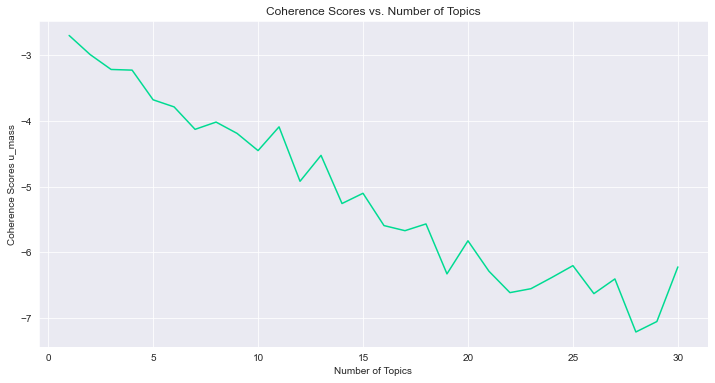

num_topics  coherence_score_u_mass  perplexity_score
0            1               -2.703296         -6.169088
1            2               -2.993494         -6.235315
2            3               -3.220268         -6.309709
3            4               -3.230345         -6.381396
4            5               -3.681343         -6.428839
5            6               -3.789355         -6.473592
7            8               -4.020428         -6.543095
10          11               -4.092851         -6.621434
6            7               -4.130649         -6.514216
8            9               -4.192240         -6.565981
9           10               -4.454119         -6.593866
12          13               -4.526280         -6.650391
11          12               -4.920623         -6.631013
14          15               -5.102969         -6.693511
13          14               -5.258717         -6.671659
17          18               -5.568962         -6.745627
15          16               -5.594103         -6.712194
16          17               -5.671710         -6.730656
19          20               -5.825408         -6.789399
24          25               -6.203270         -6.884562
29          30               -6.222760         -6.948236
20          21               -6.287938         -6.803269
18          19               -6.328314         -6.771310
23          24               -6.382472         -6.855062
26          27               -6.405443         -6.907639
22          23               -6.553867         -6.835818
21          22               -6.613652         -6.823305
25          26               -6.628751         -6.881281
28          29               -7.052941         -6.924533
27          28               -7.211857         -6.919521

In [29]:
# Load from pickle 
coherence_pros_df = find_optimal_topics(doc_term_matrix_pros, id2word_pros, lst_pros_final, min_topics=1, max_topics=30, coherence='u_mass', display=True)
coherence_pros_df
# with open('coherence_pros_df.pickle', 'wb') as f:
#     pickle.dump(coherence_pros_df, f)

**Interpretation:**

* Scores stay high through ~15 topics, and then dip off. 
* After looking at a few numbers of topics, pptimal number of topics chosen is 11. Interpretation might be different from a different assessor. 

In [56]:
lda_model_pros_12 = LdaModel(corpus=doc_term_matrix_pros, id2word=id2word_pros, num_topics=12, random_state=123, passes=25)
lda_model_pros_12.print_topics(num_words=25)

[(0,
  '0.155*"work life balance" + 0.069*"group" + 0.062*"manager" + 0.033*"deal" + 0.029*"project" + 0.025*"opportunity" + 0.021*"chance" + 0.019*"something" + 0.019*"ton" + 0.018*"none" + 0.018*"executive" + 0.018*"department" + 0.017*"knowledge" + 0.015*"part" + 0.015*"employee" + 0.014*"level" + 0.013*"time" + 0.013*"communication" + 0.011*"working" + 0.010*"exposure" + 0.010*"training" + 0.010*"pay bonus" + 0.009*"ground" + 0.008*"mind" + 0.008*"bureaucracy"'),
 (1,
  '0.174*"pay" + 0.128*"office" + 0.104*"benefit" + 0.066*"perk" + 0.055*"location" + 0.049*"lunch" + 0.030*"food" + 0.026*"snack" + 0.020*"hour" + 0.018*"gym" + 0.017*"colleague" + 0.011*"pm" + 0.010*"health benefit" + 0.009*"breakfast lunch" + 0.008*"room" + 0.008*"cafeteria" + 0.007*"job security" + 0.007*"curve" + 0.006*"meal" + 0.006*"learning experience" + 0.006*"pantry" + 0.005*"compensation package" + 0.005*"friday" + 0.005*"transportation" + 0.005*"stuff"'),
 (2,
  '0.183*"benefit" + 0.052*"everyone" + 0.043*

**pyLDAvis visualization**

In [60]:
# Visualize lda model 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_pros_12, doc_term_matrix_pros, id2word_pros)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.109486  0.080590       1        1  16.630641
7     -0.211517 -0.155339       2        1  11.118752
9      0.179852 -0.117907       3        1   9.888309
1     -0.253954  0.134091       4        1   8.107345
8      0.093930 -0.157078       5        1   7.339719
11    -0.168171 -0.223708       6        1   7.189887
3      0.095715 -0.120465       7        1   6.939978
10    -0.002599  0.168090       8        1   6.796024
4      0.111825  0.062568       9        1   6.739671
6      0.009771  0.058012      10        1   6.636275
2     -0.138079  0.166744      11        1   6.494271
0      0.173740  0.104402      12        1   6.119128, topic_info=               Term         Freq        Total Category  logprob  loglift
9            people  2490.000000  2490.000000  Default  30.0000  30.0000
40          company  1366.000000  1366.000000  Default  29.0000  29.0000
3              team   769.000000   769.000000  Default  28.0000  28.0000
0       environment   699.000000   699.000000  Default  27.0000  27.0000
4           benefit  1470.000000  1470.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
41         employee    41.249374   735.126405  Topic12  -4.1991  -0.0867
202        exposure    26.693532   185.887769  Topic12  -4.6343   0.8530
136  responsibility    20.305157   127.522578  Topic12  -4.9079   0.9563
103          career    19.823683   212.949026  Topic12  -4.9319   0.4196
115      investment    17.906947   169.800590  Topic12  -5.0336   0.5443

[605 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
199       1  0.248901  ability
199       7  0.616326  ability
199      12  0.130377  ability
160       8  0.631818   access
160      10  0.362710   access
...     ...       ...      ...
36        1  0.206289     year
36        3  0.194613     year
36        5  0.120660     year
36        9  0.108983     year
36       11  0.365872     year

[741 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 10, 2, 9, 12, 4, 11, 5, 7, 3, 1])

**Wordcloud Visualization**

Total plots: 12, Total cols: 4, Total rows: 3


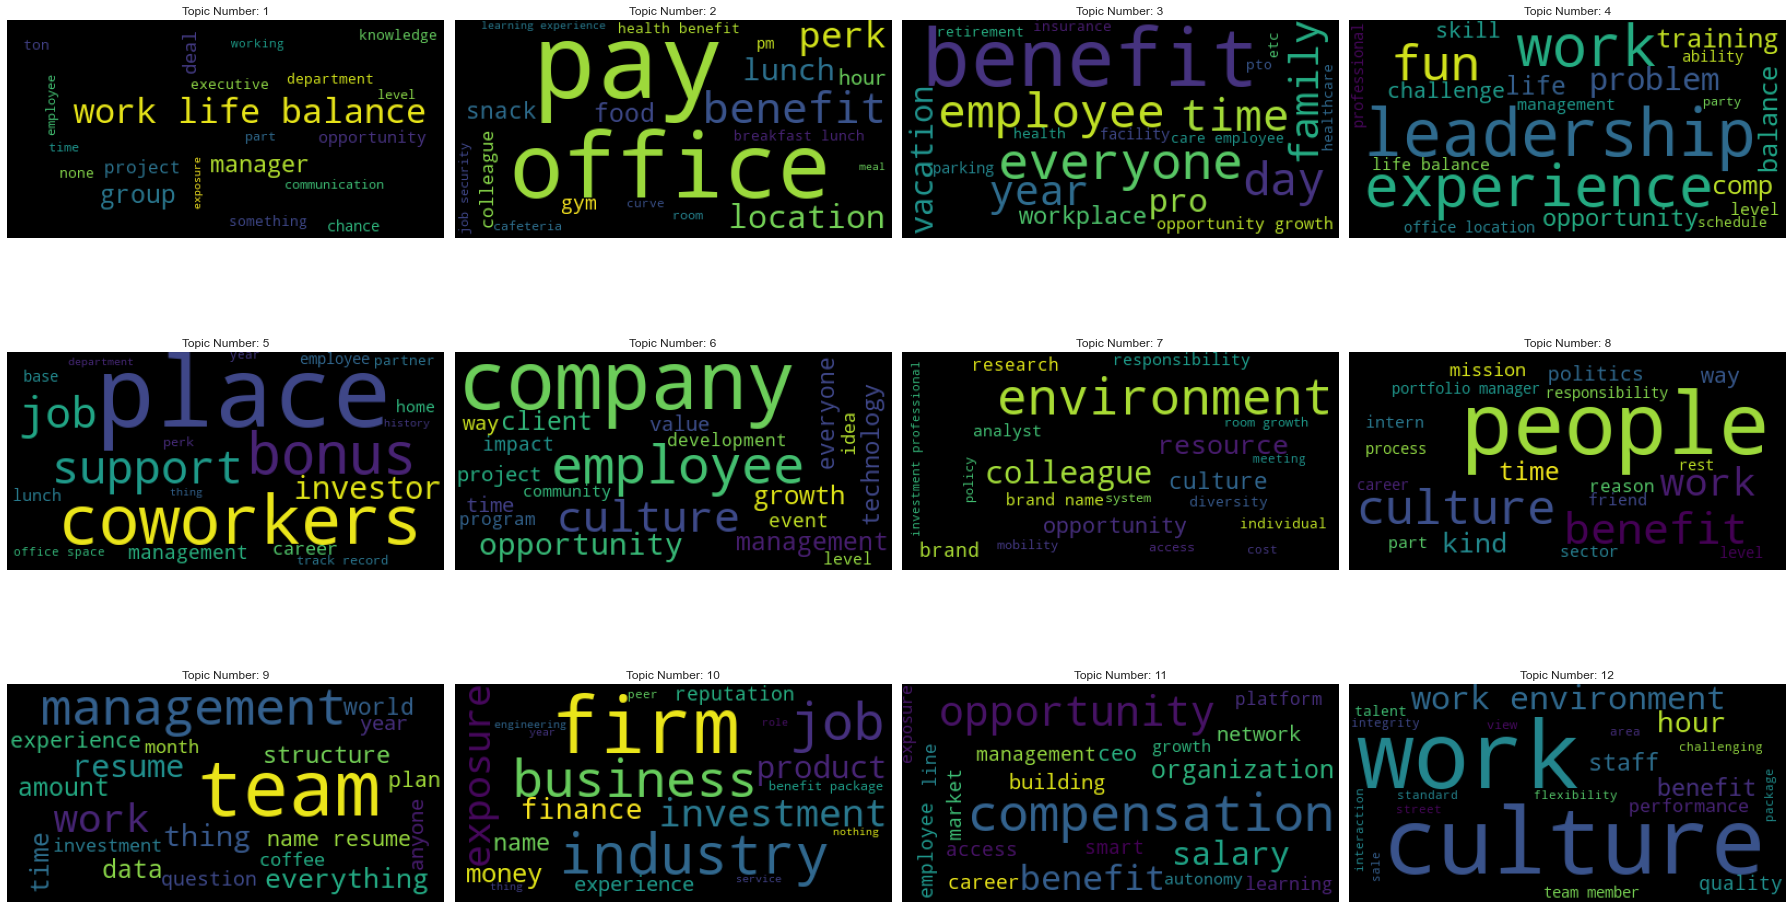

In [90]:
plot_wordclouds_lda(lda_model_pros_12)

**5 main categories of topics:**
* People 
* Company culture 
* Pay, benefits and perks
* Firm's business 
* Role, opportunity and growth 

**Individual Topics:** TODO 
* Topic 
* Topic 6
* Topic 

#### Pros - LDA - Pandemic

In [130]:
# get the id2word and corpus (ids in place of words)
id2word_pandemic_pros, doc_term_matrix_pandemic_pros = get_id2word_doc_matrix(lst_pros_final_pandemic) # lst_pros_final_pandemic = get_bigrams_trigrams(lst_corpus_pros_pandemic_nouns)

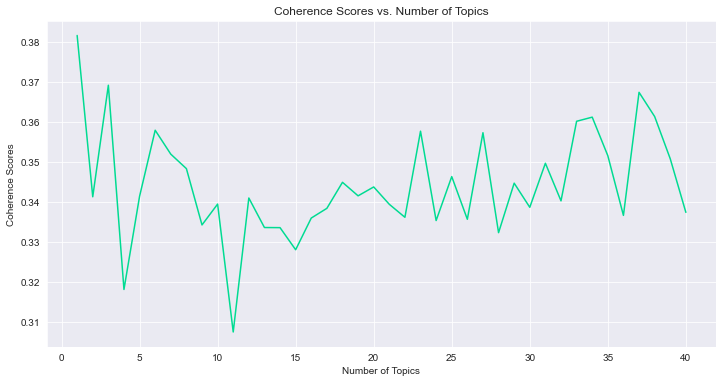

num_topics  coherence_score
0            1         0.381729
2            3         0.369253
36          37         0.367478
37          38         0.361407
33          34         0.361256
32          33         0.360219
5            6         0.357974
22          23         0.357738
26          27         0.357356
6            7         0.351981
34          35         0.351589
38          39         0.350814
30          31         0.349698
7            8         0.348351
24          25         0.346353
17          18         0.344925
28          29         0.344708
19          20         0.343762
18          19         0.341533
4            5         0.341416
1            2         0.341294
11          12         0.340989
31          32         0.340276
9           10         0.339463
20          21         0.339411
29          30         0.338657
16          17         0.338399
39          40         0.337389
35          36         0.336630
21          22         0.336153
15          16         0.335964
25          26         0.335656
23          24         0.335339
8            9         0.334240
12          13         0.333589
13          14         0.333559
27          28         0.332302
14          15         0.328020
3            4         0.318065
10          11         0.307409

In [372]:
# get the optimal num of topics from coherence score and perplexity score 
coherence_pros_df_pandemic = find_optimal_topics(doc_term_matrix_pandemic_pros, id2word_pandemic_pros, 
                                                 lst_pros_final_pandemic, min_topics=1, max_topics=30, display=True)
coherence_pros_df_pandemic

# with open('coherence_pros_df.pickle', 'wb') as f:
#     pickle.dump(coherence_pros_df, f)

In [131]:
# Take the number of topics from above and create a model to print topics 
lda_model_pandemic_pros_12 = LdaModel(corpus=doc_term_matrix_pandemic_pros, id2word=id2word_pandemic_pros, 
                              num_topics=12, random_state=123, passes=25)
lda_model_pandemic_pros_12.print_topics()

[(0,
  '0.166*"work life balance" + 0.102*"team" + 0.048*"compensation" + 0.042*"deal" + 0.027*"opportunity" + 0.025*"structure" + 0.020*"exposure" + 0.019*"base" + 0.016*"room" + 0.015*"investment"'),
 (1,
  '0.082*"management" + 0.040*"industry" + 0.040*"everyone" + 0.035*"product" + 0.033*"team" + 0.029*"client" + 0.019*"opportunity growth" + 0.018*"focus" + 0.018*"service" + 0.017*"success"'),
 (2,
  '0.202*"work" + 0.184*"environment" + 0.115*"people" + 0.031*"culture" + 0.024*"team" + 0.018*"management" + 0.016*"office" + 0.015*"balance" + 0.015*"life" + 0.010*"part"'),
 (3,
  '0.405*"people" + 0.119*"opportunity" + 0.049*"benefit" + 0.036*"perk" + 0.028*"learning" + 0.015*"compensation" + 0.015*"career" + 0.012*"group" + 0.011*"project" + 0.010*"industry"'),
 (4,
  '0.217*"place" + 0.048*"coworkers" + 0.032*"reputation" + 0.024*"money" + 0.024*"project" + 0.020*"market" + 0.019*"benefit" + 0.018*"manager" + 0.016*"technology" + 0.016*"performance"'),
 (5,
  '0.115*"colleague" + 

In [132]:
# Visualize lda model 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_pandemic_pros_12, doc_term_matrix_pandemic_pros, id2word_pandemic_pros)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.160417  0.195601       1        1  13.772482
2      0.247193 -0.153969       2        1  10.741042
3      0.081752 -0.269993       3        1  10.224154
7      0.019291 -0.004007       4        1   8.899689
6     -0.188579 -0.044805       5        1   7.898515
10    -0.183087 -0.074433       6        1   7.809237
9      0.097351  0.050552       7        1   7.347441
8      0.036548  0.098181       8        1   7.207266
4     -0.119046  0.053352       9        1   7.081086
0     -0.055134 -0.022212      10        1   6.666670
1      0.047165  0.146986      11        1   6.214890
5     -0.143869  0.024749      12        1   6.137527, topic_info=             Term        Freq       Total Category  logprob  loglift
9          people  847.000000  847.000000  Default  30.0000  30.0000
29        culture  496.000000  496.000000  Default  29.0000  29.0000
40        company  432.000000  432.000000  Default  28.0000  28.0000
8            work  426.000000  426.000000  Default  27.0000  27.0000
0     environment  304.000000  304.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
56        manager    9.335367   61.703272  Topic12  -4.6154   0.9022
73   compensation   11.654431  143.900350  Topic12  -4.3935   0.2773
52         leader    7.645946   35.464739  Topic12  -4.8150   1.2564
205      exposure    8.335072   68.688337  Topic12  -4.7287   0.6816
2      management    7.541315  181.157720  Topic12  -4.8288  -0.3882

[628 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
137       1  0.080384      ability
137       6  0.482307      ability
137       9  0.281346      ability
137      10  0.160769      ability
1600      6  0.917884  accelerator
...     ...       ...          ...
36        4  0.080059         year
36        8  0.128095         year
36       11  0.080059         year
140       1  0.828758     year end
140      10  0.075342     year end

[912 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 3, 4, 8, 7, 11, 10, 9, 5, 1, 2, 6])

**WordCloud visualization**

Total plots: 12, Total cols: 4, Total rows: 3


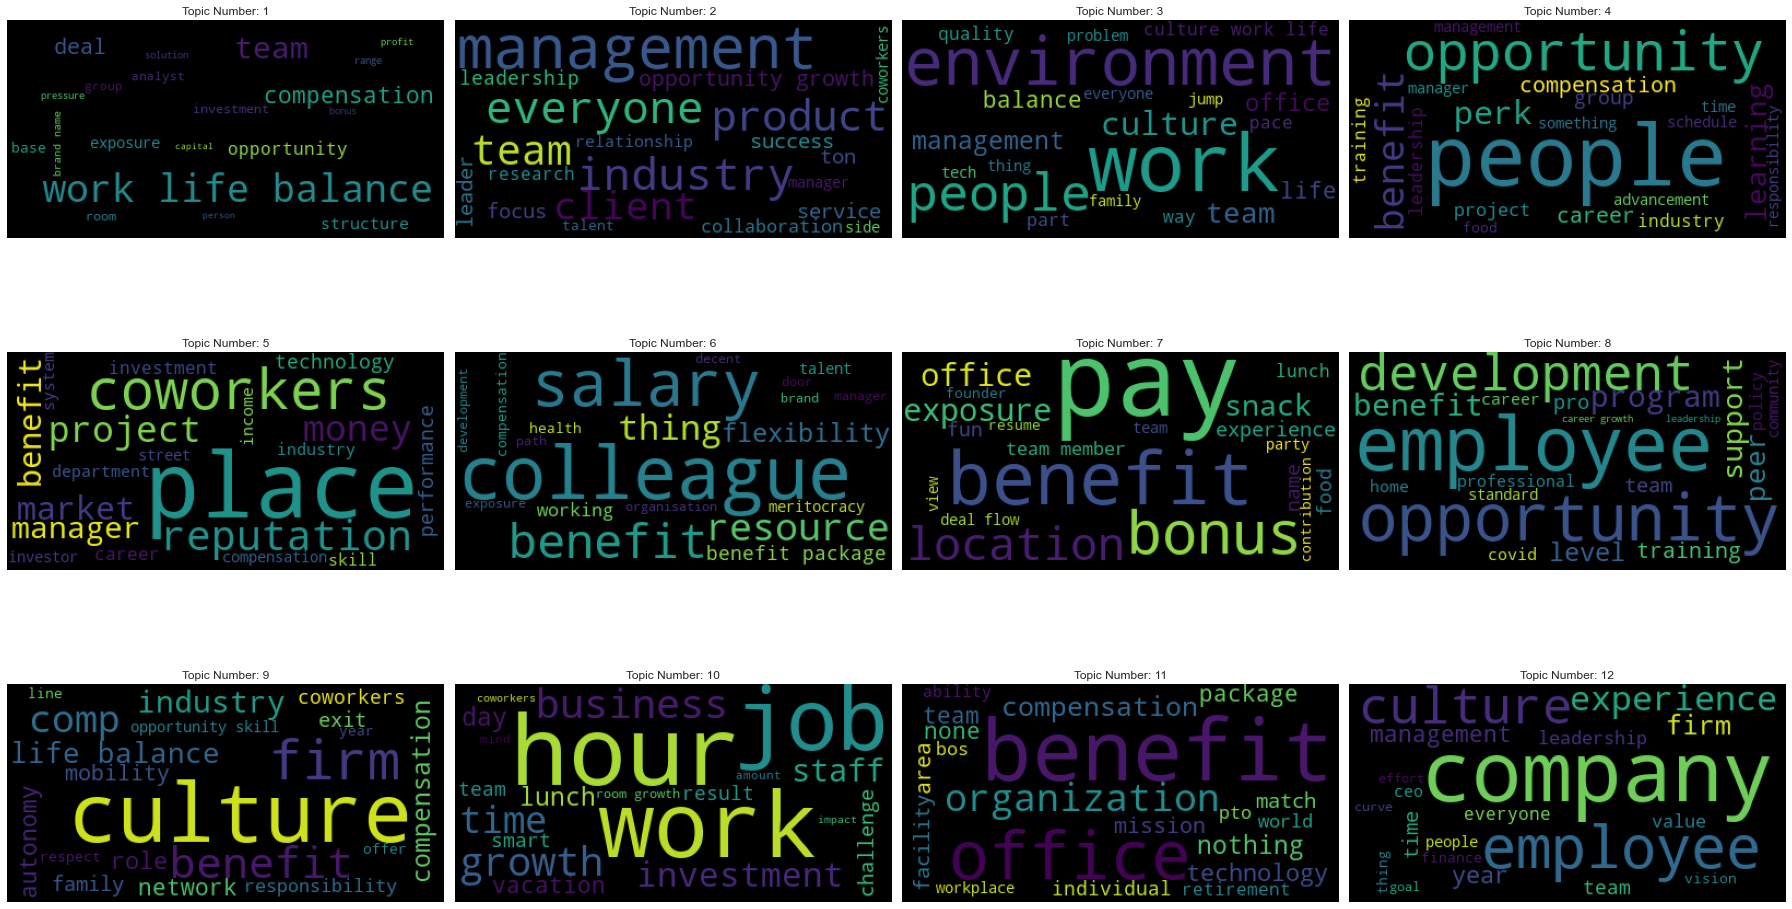

In [71]:
plot_wordclouds_lda(lda_model_pandemic_pros_12)

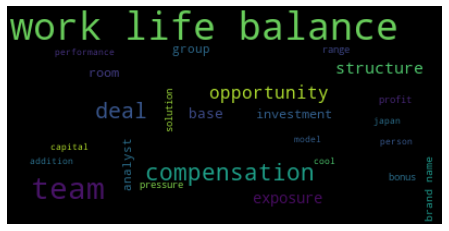

In [74]:
plot_wordcloud_lda(lda_model_pandemic_pros_12, 0, num_words=25)

**Interpretation:** 
* Similar to the bigrams analyis, themes about office and location appear lesser during the pandemic reviews topic modeling. Otherwise, topics look fairly similar when looking at all reviews together. 

<a id='gsdmm_pros'></a>
### Pros - Top Companies 
* Bigrams
* LDA 
* GSDMM

*What are lower rated firms doing poorly?* 

[LDA vs. GSDMM](https://towardsdatascience.com/short-text-topic-modelling-lda-vs-gsdmm-20f1db742e14)

* While LDA performs very well on larger texts (>50 words or so), its performance tends to nose-dive when trying to model the topics of shorter texts, for the pretty obvious reason that a short text (such as a Tweet or the title of a forum question) is likely to refer to only a single topic.

[GSDMM source](https://github.com/rwalk/gsdmm)

In [105]:
top_companies_df_pandemic = df_pandemic[df_pandemic.company.apply(lambda x: x in top_companies)]

#### Bigrams

In [104]:
lst_corpus_pros_top = top_companies_df_pandemic['pros_cleaned'].map(word_tokenize).values
tokens_pros_top = list(itertools.chain(*lst_corpus_pros_top))
display_bigrams(tokens_pros_top)

Top Bigrams Based on Raw Frequency: 
(('smart', 'people'), 0.008714596949891068)
(('life', 'balance'), 0.008351488743645606)
(('work', 'life'), 0.008351488743645606)
(('good', 'pay'), 0.005809731299927378)
(('great', 'people'), 0.005083514887436456)
(('people', 'great'), 0.005083514887436456)
(('great', 'benefit'), 0.004357298474945534)
(('place', 'work'), 0.004357298474945534)
(('interesting', 'work'), 0.0039941902687000725)
(('work', 'culture'), 0.0039941902687000725)

Top Bigrams Based on PMI: 
('life', 'balance')
('work', 'life')
('smart', 'people')
('interesting', 'work')
('place', 'work')
('good', 'pay')
('great', 'place')
('great', 'benefit')
('work', 'culture')
('great', 'people')


#### GSDMM - Top Companies

In [107]:
lst_corpus_pros_top = top_companies_df_pandemic['pros_cleaned'].map(word_tokenize).values
tokens_pros_top = list(itertools.chain(*lst_corpus_pros_top))

# Note that GSDMM only requires two input variables: the documents as a numpy array and the length of your dictionary/vocabulary.
lst_pros_top_final = get_bigrams_trigrams(lst_corpus_pros_top)
id2word_pros_top, doc_term_matrix_pros_top = get_id2word_doc_matrix(lst_pros_top_final) # lst_pros_final_pandemic = get_bigrams_trigrams(lst_corpus_pros_pandemic_nouns)

In [108]:
# initialize GSDMM
gsdmm = MovieGroupProcess(K=15, alpha=0.1, beta=0.3, n_iters=50)
vocab_len = len(id2word_pros_top)
# fit GSDMM model
y = gsdmm.fit(lst_pros_top_final, vocab_len) #total_word_count = len(tokens)

# number of docs per topic 
doc_count = np.array(gsdmm.cluster_doc_count)
# print('Number of documents per topic :', doc_count)

# sort the indexes by importance 
indexes_sorted = doc_count.argsort()[::-1]
print(f'Index of docs arranged by importance: {indexes_sorted}')
"""This will generate a list of the total number of clusters, 
with the top {num_words} most-recurring words, and the number of times each of those top {num_words} words occurs in the topic."""
top_words_gsdmm(gsdmm.cluster_word_distribution, indexes_sorted, 30)

Total plots: 9, Total cols: 4, Total rows: 3


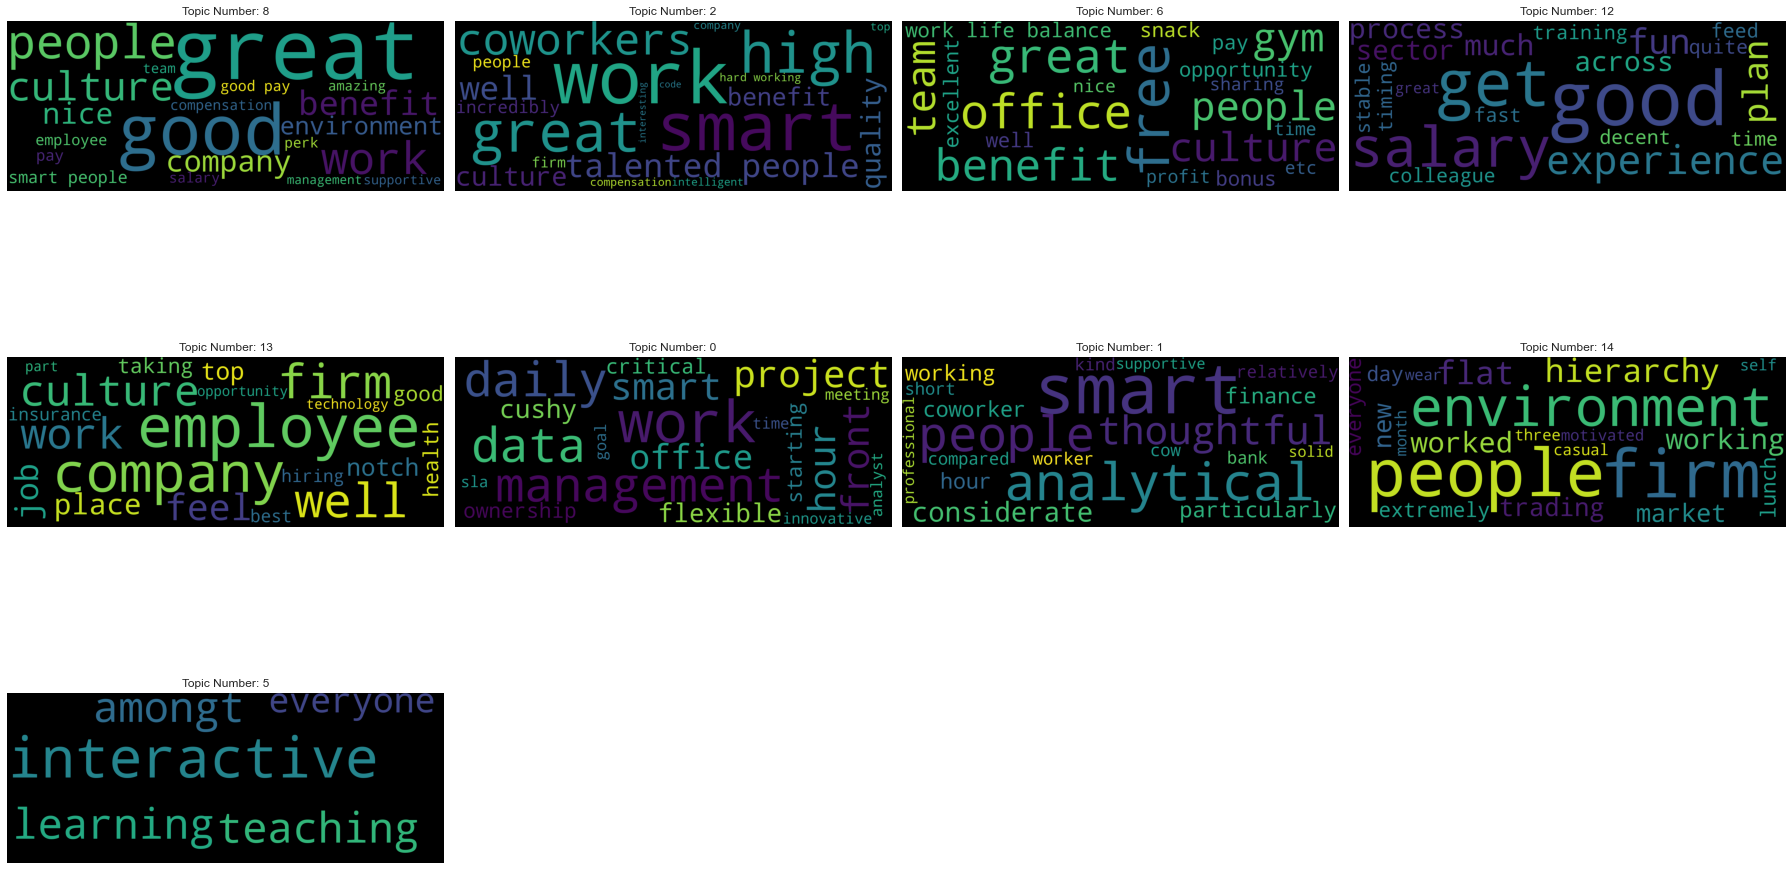

In [110]:
plot_wordclouds_gsdmm(gsdmm.cluster_word_distribution, indexes_sorted)

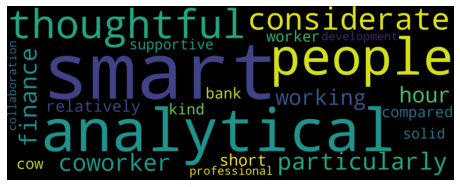

In [119]:
 plot_wordcloud_gsdmm(gsdmm.cluster_word_distribution, 1, 25)

#### LDA - Top Companies

In [124]:
lst_corpus_pros_top = top_companies_df_pandemic['pros_cleaned_nouns'].map(word_tokenize).values
tokens_pros_top = list(itertools.chain(*lst_corpus_pros_top))

# Note that GSDMM only requires two input variables: the documents as a numpy array and the length of your dictionary/vocabulary.
lst_pros_top_final = get_bigrams_trigrams(lst_corpus_pros_top)
id2word_pros_top, doc_term_matrix_pros_top = get_id2word_doc_matrix(lst_pros_top_final) # lst_pros_final_pandemic = get_bigrams_trigrams(lst_corpus_pros_pandemic_nouns)

In [125]:
lda_model_pros_top = LdaModel(corpus=doc_term_matrix_pros_top, id2word=id2word_pros_top, num_topics=5, random_state=123, passes=25)
# lda_model_pros_top.print_topics(num_words=30)

Total plots: 5, Total cols: 4, Total rows: 2


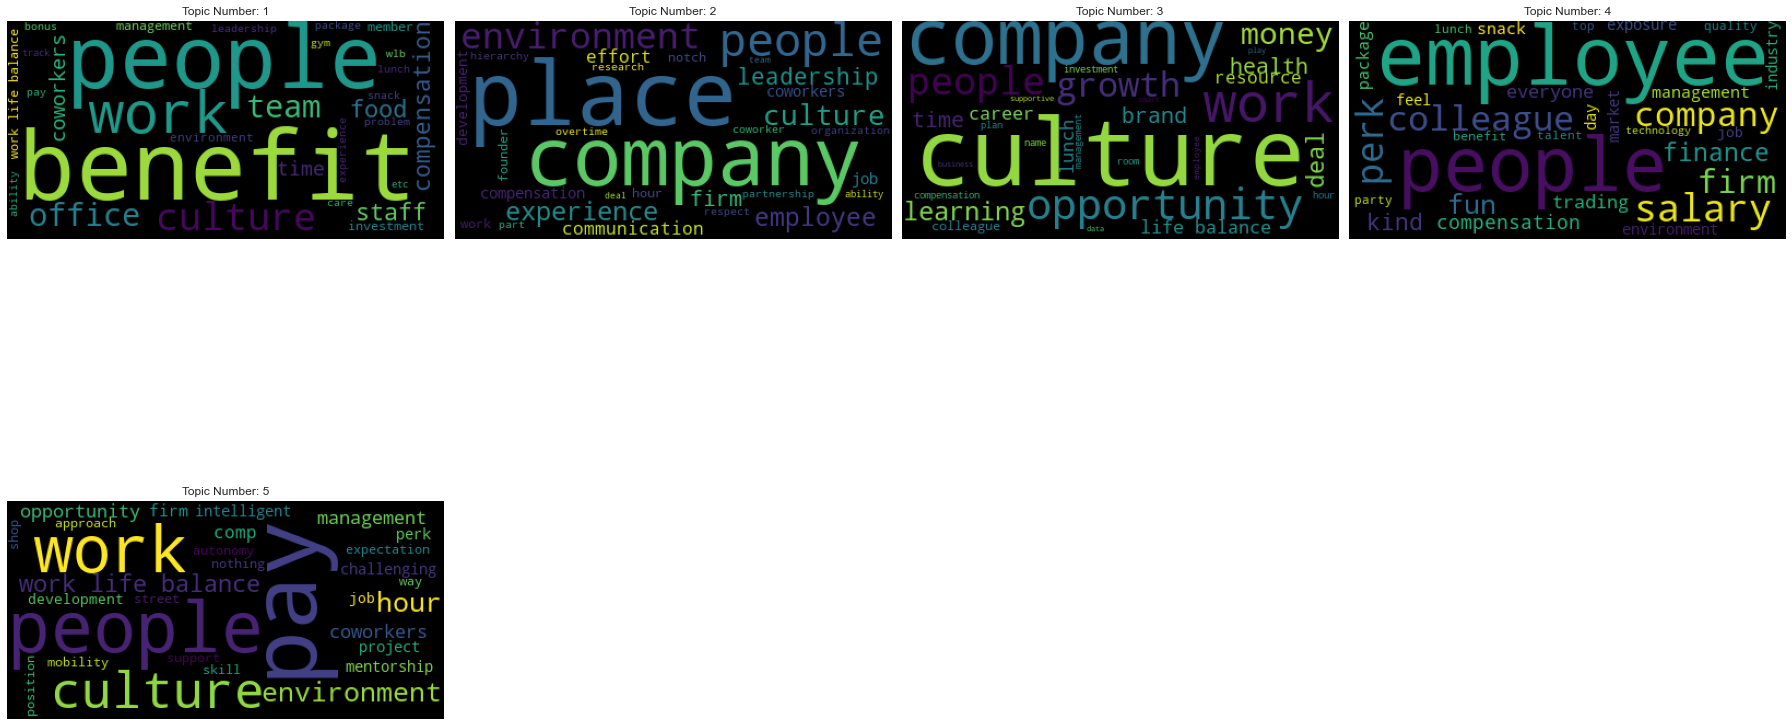

In [ ]:
plot_wordclouds_lda(lda_model_pros_top,num_words=30)

In [127]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_pros_top, doc_term_matrix_pros_top, id2word_pros_top)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.141110  0.021500       1        1  26.431194
3     -0.167650  0.069291       2        1  20.710332
2     -0.015101 -0.158779       3        1  19.501571
4      0.081413  0.073351       4        1  18.501534
1     -0.039772 -0.005363       5        1  14.855370, topic_info=        Term       Freq      Total Category  logprob  loglift
31   benefit  40.000000  40.000000  Default  30.0000  30.0000
9        pay  28.000000  28.000000  Default  29.0000  29.0000
19     place  19.000000  19.000000  Default  28.0000  28.0000
17   company  35.000000  35.000000  Default  27.0000  27.0000
15  employee  21.000000  21.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
68      hour   1.838735  12.405579   Topic5  -4.7067  -0.0023
86   ability   1.152324   3.847798   Topic5  -5.1740   0.7011
11      work   1.834736  48.385567   Topic5  -4.7089  -1.3655
65      deal   0.966007   6.173433   Topic5  -5.3503   0.0520
46      team   0.987933  15.616557   Topic5  -5.3279  -0.8537

[278 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
86        1  0.519778            ability
86        5  0.259889            ability
287       3  0.644748        advancement
322       1  0.641752                afk
80        5  0.660440            america
...     ...       ...                ...
32        1  0.300178  work life balance
32        2  0.075044  work life balance
32        4  0.600355  work life balance
277       5  0.660437            working
16        2  0.846627          workplace

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 2])

<a id='cons_column'></a>
## 3. Analyzing Cons Column
* Most common words 
* Bigrams and trigrams 
* LDA 
* GSDMM 

### Creating tokenized lists

In [47]:
# All reviews 
lst_corpus_cons_nouns = df['cons_cleaned_nouns'].map(word_tokenize).values
tokens_cons_nouns = list(itertools.chain(*lst_corpus_cons_nouns))

# Pandemic
lst_corpus_cons_pandemic_nouns = df_pandemic['cons_cleaned_nouns'].map(word_tokenize).values
tokens_cons_pandemic_nouns = list(itertools.chain(*lst_corpus_cons_pandemic_nouns))

### Cons - Most Common Words

In [49]:
# 1A. All reviews

print(most_common_words(tokens_cons_nouns, 25, display=True))

# 1B. Pandemiclst_corpus_cons_pandemic = df_pandemic['cons_cleaned'].map(word_tokenize).values

print(most_common_words(tokens_cons_pandemic_nouns, 25, display=True))

There are 4422 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

work: 0.027720180835514464
management: 0.025884632380434414
people: 0.02393011319215473
company: 0.020496957748393895
hour: 0.017709643427716783
culture: 0.01685985247629083
time: 0.016689894286005643
employee: 0.01577212005846562
team: 0.01437846289812706
firm: 0.011489173663278833
life: 0.011132261463679934
manager: 0.010928311635337707
year: 0.009755600122369897
job: 0.009738604303341378
office: 0.009126754818314695
balance: 0.009058771542200618
growth: 0.008735850980658757
place: 0.008480913695230973
environment: 0.00836194296203134
day: 0.007461164553519834
career: 0.0073082021822631635
pay: 0.007274210544206125
opportunity: 0.007002277439749822
lack: 0.006900302525578708
thing: 0.006543390325979809
None
There are 2398 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

work: 0.03511957254759558
hour: 0.02469263889609379
management: 0

### Cons - Bigrams 

#### Cons - Bigrams - All reviews|

In [50]:
lst_corpus_cons = df['cons_cleaned'].map(word_tokenize).values
tokens_cons = list(itertools.chain(*lst_corpus_cons))
display_bigrams(tokens_cons)

Top Bigrams Based on Raw Frequency: 
(('work', 'life'), 0.004404200423986458)
(('life', 'balance'), 0.00423164779543475)
(('long', 'hour'), 0.004009794415868268)
(('senior', 'management'), 0.001248952359040936)
(('upper', 'management'), 0.0009284974774449064)
(('place', 'work'), 0.0009038471019375196)
(('work', 'environment'), 0.0008298959754153588)
(('high', 'turnover'), 0.0008052455999079719)
(('working', 'hour'), 0.0007641616407289938)
(('work', 'hour'), 0.0006737769305352418)

Top Bigrams Based on PMI: 
('kool', 'aid')
('sink', 'swim')
('tuition', 'reimbursement')
('inner', 'circle')
('red', 'tape')
('jersey', 'city')
('frowned', 'upon')
('class', 'citizen')
('sub', 'par')
('health', 'insurance')


#### Cons - Bigrams - Pandemic

In [51]:
lst_corpus_cons_pandemic = df_pandemic['cons_cleaned'].map(word_tokenize).values
tokens_cons_pandemic = list(itertools.chain(*lst_corpus_cons_pandemic))
display_bigrams(tokens_cons_pandemic)

Top Bigrams Based on Raw Frequency: 
(('work', 'life'), 0.006182301246678929)
(('life', 'balance'), 0.00592683425301451)
(('long', 'hour'), 0.00592683425301451)
(('working', 'hour'), 0.001583895360719395)
(('place', 'work'), 0.0010985080727569999)
(('upper', 'management'), 0.001072961373390558)
(('senior', 'management'), 0.0009963212752912324)
(('none', 'think'), 0.0009707745759247905)
(('none', 'none'), 0.000894134477825465)
(('work', 'environment'), 0.000894134477825465)

Top Bigrams Based on PMI: 
('boy', 'club')
('cut', 'throat')
('growing', 'pain')
('white', 'male')
('word', 'word')
('non', 'existent')
('upward', 'mobility')
('fast', 'paced')
('old', 'school')
('diversity', 'inclusion')


### Cons - LDA

In [57]:
lst_cons_final_pandemic = get_bigrams_trigrams(lst_corpus_cons_pandemic_nouns)
# print(len(lst_cons_final), len(lst_corpus_cons))

In [59]:
# Load from pickle 
id2word_cons, doc_term_matrix_cons = get_id2word_doc_matrix(lst_cons_final_pandemic)
# coherence_pros_df_pandemic = find_optimal_topics(doc_term_matrix_pandemic, id2word_pandemic, 
#                                                  lst_cons_final_pandemic, min_topics=1, max_topics=40, display=True)
# coherence_pros_df_pandemic

In [60]:
# Take the number of topics from above and create a model to print topics 
lda_model_cons = LdaModel(corpus=doc_term_matrix_cons, id2word=id2word_cons, 
                              num_topics=12, random_state=123, passes=25)
lda_model_cons.print_topics()

[(0,
  '0.044*"salary" + 0.041*"pay" + 0.039*"firm" + 0.039*"mobility" + 0.036*"environment" + 0.036*"group" + 0.031*"opportunity" + 0.027*"diversity" + 0.027*"benefit" + 0.027*"bonus"'),
 (1,
  '0.039*"manager" + 0.032*"employee" + 0.028*"culture" + 0.025*"team" + 0.024*"management" + 0.022*"people" + 0.022*"year" + 0.017*"job" + 0.013*"company" + 0.012*"firm"'),
 (2,
  '0.148*"work life balance" + 0.051*"compensation" + 0.031*"issue" + 0.020*"everyone" + 0.018*"pm" + 0.018*"performance" + 0.018*"culture" + 0.017*"growth opportunity" + 0.017*"moment" + 0.015*"environment"'),
 (3,
  '0.110*"people" + 0.043*"process" + 0.024*"role" + 0.023*"business" + 0.022*"leadership" + 0.021*"culture" + 0.019*"investment" + 0.017*"support" + 0.014*"everything" + 0.013*"opportunity"'),
 (4,
  '0.055*"office" + 0.038*"politics" + 0.034*"thing" + 0.031*"company" + 0.029*"bit" + 0.025*"department" + 0.021*"management" + 0.016*"communication" + 0.013*"level" + 0.012*"culture"'),
 (5,
  '0.062*"team" + 0.

**pyLDAvis visualization**

In [61]:
# Visualize lda model 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_cons, doc_term_matrix_pandemic, id2word_pandemic)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.074207 -0.090721       1        1  23.472456
11     0.029500 -0.088741       2        1  10.055068
3      0.069779 -0.057699       3        1   8.267353
5      0.120958 -0.022768       4        1   7.945082
7     -0.331153 -0.120202       5        1   7.923824
4      0.152539 -0.038085       6        1   7.906162
8      0.036187 -0.110067       7        1   7.548227
0     -0.004020  0.207275       8        1   6.340764
6      0.042404 -0.005421       9        1   6.282729
9     -0.098677 -0.004096      10        1   5.139618
2     -0.058501  0.088716      11        1   5.080811
10    -0.033224  0.241809      12        1   4.037904, topic_info=            Term        Freq       Total Category  logprob  loglift
128         hour  372.000000  372.000000  Default  30.0000  30.0000
136         time  290.000000  290.000000  Default  29.0000  29.0000
6        company  315.000000  315.000000  Default  28.0000  28.0000
69           con  137.000000  137.000000  Default  27.0000  27.0000
123         work  330.000000  330.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
825      mistake    3.269899   10.960674  Topic12  -5.4213   1.9999
483     research    3.140864   13.312859  Topic12  -5.4615   1.7652
65           job    6.096895  144.302965  Topic12  -4.7983   0.0453
47   performance    4.208275   43.939142  Topic12  -5.1690   0.8637
677    complaint    2.685015    7.982935  Topic12  -5.6183   2.1198

[685 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
768       5  0.557811   accounting
768       7  0.334687   accounting
307       4  0.828961  acquisition
785       9  0.824598        admin
841       1  0.216399  advancement
...     ...       ...          ...
97        6  0.013065         year
97        7  0.032662         year
97       12  0.130648         year
1016      8  0.935186         york
1199      2  0.922032         zero

[1119 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 12, 4, 6, 8, 5, 9, 1, 7, 10, 3, 11])

**WordCloud visualization**

Total plots: 12, Total cols: 4, Total rows: 3


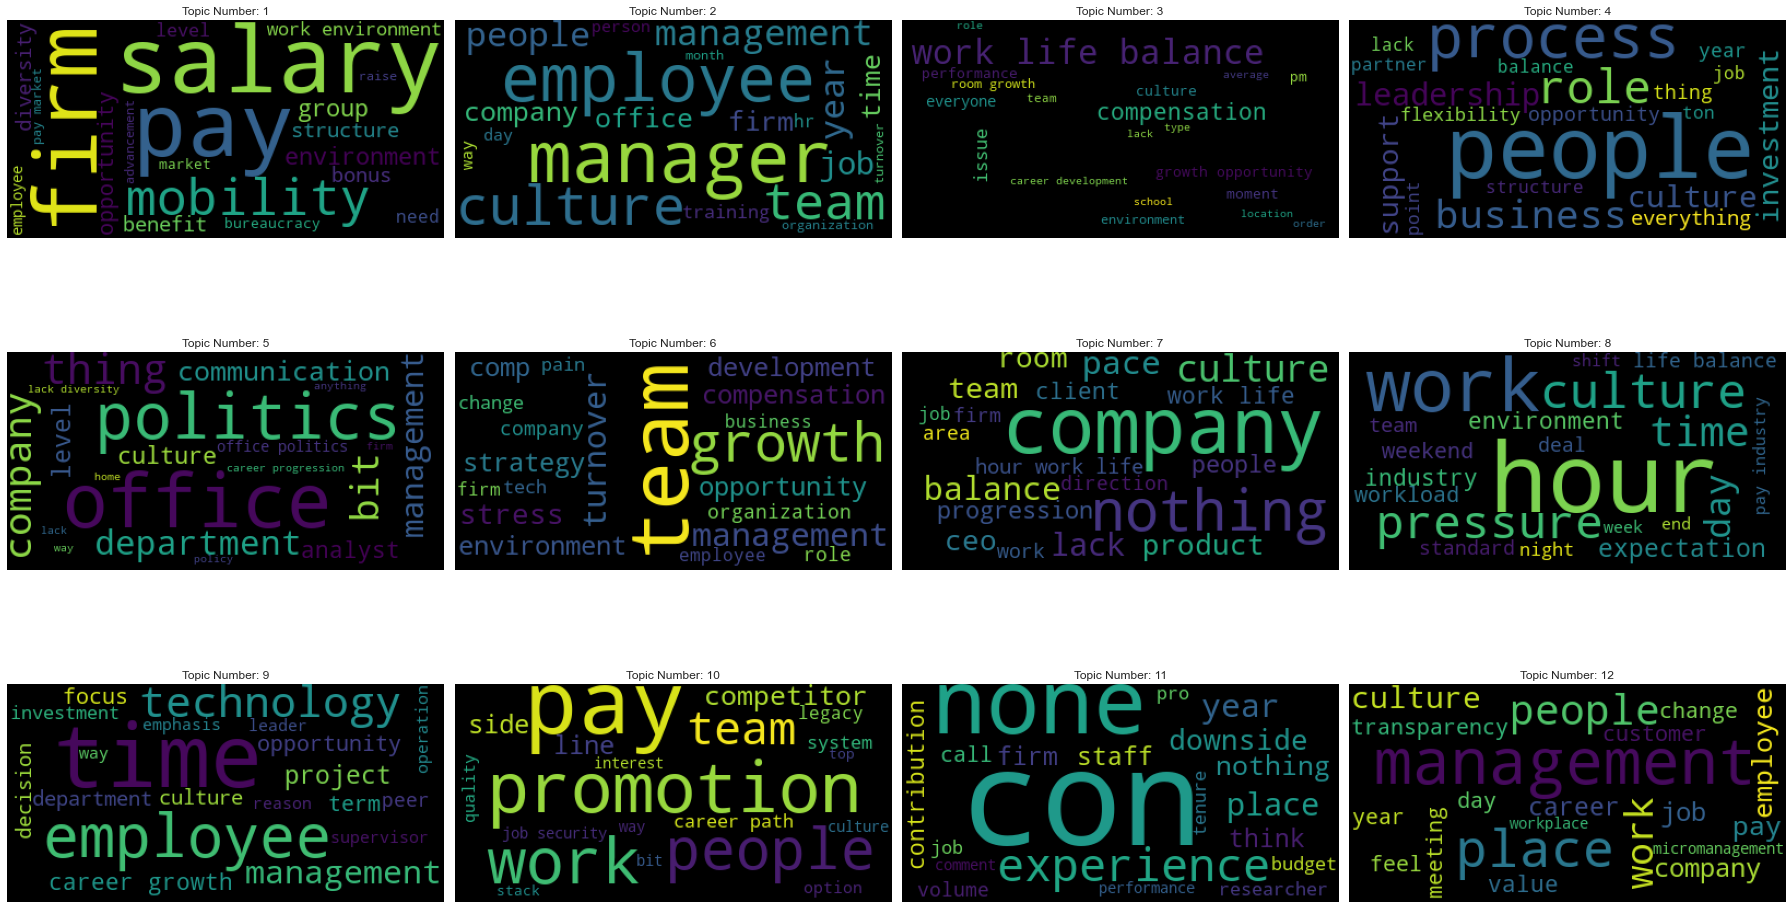

In [62]:
plot_wordclouds_lda(lda_model_cons)

<a id=''></a>
### Cons - Lowest Companies 
* Bigrams
* GSDMM
* LDA 

*What are lower rated firms doing poorly?* 

#### Bigrams

In [138]:
low_companies_df_pandemic = df_pandemic[df_pandemic.company.apply(lambda x: x in low_companies)]

lst_corpus_pros_low = low_companies_df_pandemic['cons_cleaned'].map(word_tokenize).values
tokens_cons_low = list(itertools.chain(*lst_corpus_pros_low))
display_bigrams(tokens_cons_low)

Top Bigrams Based on Raw Frequency: 
(('long', 'hour'), 0.007074829931972789)
(('life', 'balance'), 0.0069387755102040816)
(('work', 'life'), 0.0069387755102040816)
(('working', 'hour'), 0.0035374149659863946)
(('work', 'hour'), 0.0017687074829931973)
(('hard', 'work'), 0.0013605442176870747)
(('long', 'working'), 0.0013605442176870747)
(('word', 'word'), 0.0013605442176870747)
(('culture', 'mean'), 0.0012244897959183673)
(('none', 'none'), 0.0012244897959183673)

Top Bigrams Based on PMI: 
('word', 'word')
('life', 'balance')
('long', 'hour')
('work', 'life')
('working', 'hour')
('long', 'working')
('hard', 'work')
('work', 'hour')


#### GSDMM - Low Companies

In [139]:
# get tokenized lists 
lst_corpus_pros_low = low_companies_df_pandemic['cons_cleaned'].map(word_tokenize).values
lst_cons_low_final = get_bigrams_trigrams(lst_corpus_pros_low)
id2word_cons_low, doc_term_matrix_cons_low = get_id2word_doc_matrix(lst_cons_low_final) 

In [140]:
# initialize GSDMM
gsdmm = MovieGroupProcess(K=15, alpha=0.1, beta=0.3, n_iters=50)
vocab_len = len(id2word_cons_low)
# fit GSDMM model
y = gsdmm.fit(lst_cons_low_final, vocab_len) #total_word_count = len(tokens)

# number of docs per topic 
doc_count = np.array(gsdmm.cluster_doc_count)
# print('Number of documents per topic :', doc_count)

# sort the indexes by importance 
indexes_sorted = doc_count.argsort()[::-1]
print(f'Index of docs arranged by importance: {indexes_sorted}')
"""This will generate a list of the total number of clusters, 
with the top {num_words} most-recurring words, and the number of times each of those top {num_words} words occurs in the topic."""
top_words_gsdmm(gsdmm.cluster_word_distribution, indexes_sorted, 25)

In stage 0: transferred 589 clusters with 15 clusters populated
In stage 1: transferred 385 clusters with 15 clusters populated
In stage 2: transferred 319 clusters with 14 clusters populated
In stage 3: transferred 247 clusters with 12 clusters populated
In stage 4: transferred 235 clusters with 10 clusters populated
In stage 5: transferred 196 clusters with 11 clusters populated
In stage 6: transferred 188 clusters with 12 clusters populated
In stage 7: transferred 199 clusters with 10 clusters populated
In stage 8: transferred 199 clusters with 9 clusters populated
In stage 9: transferred 171 clusters with 9 clusters populated
In stage 10: transferred 176 clusters with 8 clusters populated
In stage 11: transferred 169 clusters with 10 clusters populated
In stage 12: transferred 171 clusters with 11 clusters populated
In stage 13: transferred 180 clusters with 11 clusters populated
In stage 14: transferred 176 clusters with 10 clusters populated
In stage 15: transferred 184 clusters 

Total plots: 10, Total cols: 4, Total rows: 3


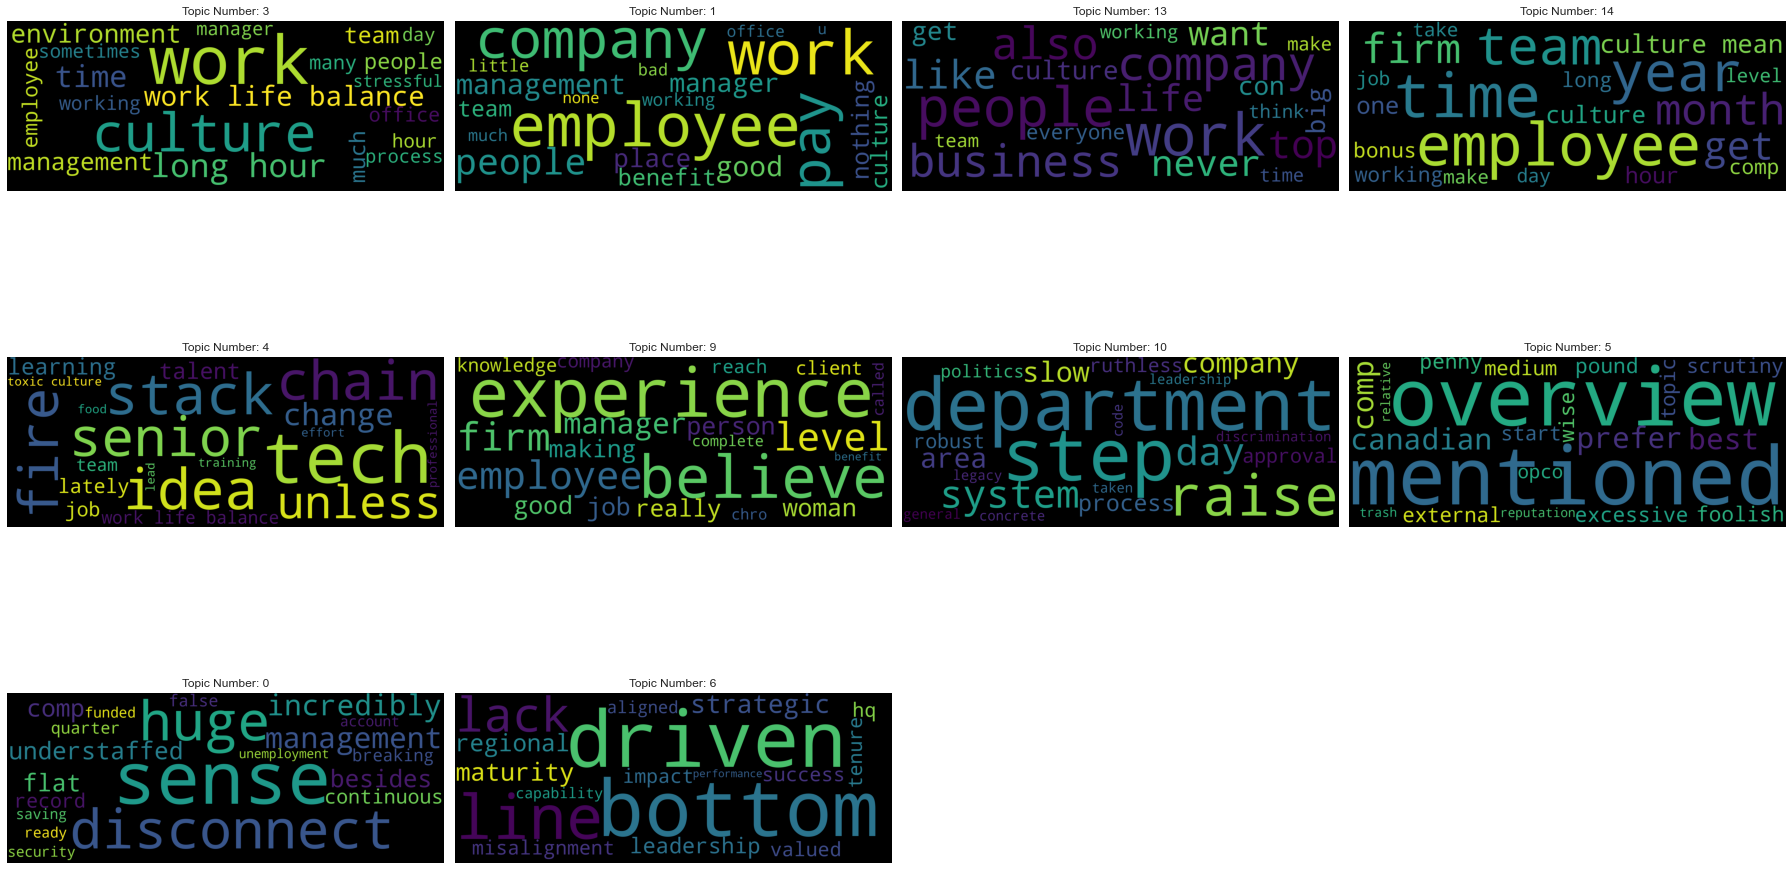

In [141]:
plot_wordclouds_gsdmm(gsdmm.cluster_word_distribution, indexes_sorted)

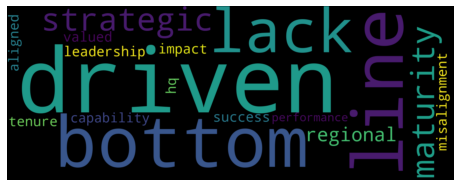

In [157]:
 plot_wordcloud_gsdmm(gsdmm.cluster_word_distribution, 6, 25)

#### LDA - Lowest Rated Companies

In [98]:
lst_corpus_pros_low = low_companies_df_pandemic['cons_cleaned_nouns'].map(word_tokenize).values
lst_cons_low_final = get_bigrams_trigrams(lst_corpus_pros_low)
id2word_cons_low, doc_term_matrix_cons_low = get_id2word_doc_matrix(lst_cons_low_final) # lst_pros_final_pandemic = get_bigrams_trigrams(lst_corpus_pros_pandemic_nouns)

lda_model_cons_low = LdaModel(corpus=doc_term_matrix_cons_low, id2word=id2word_cons_low, num_topics=5, random_state=123, passes=25)
# lda_model_cons_low.print_topics(num_words=25)

Total plots: 5, Total cols: 4, Total rows: 2


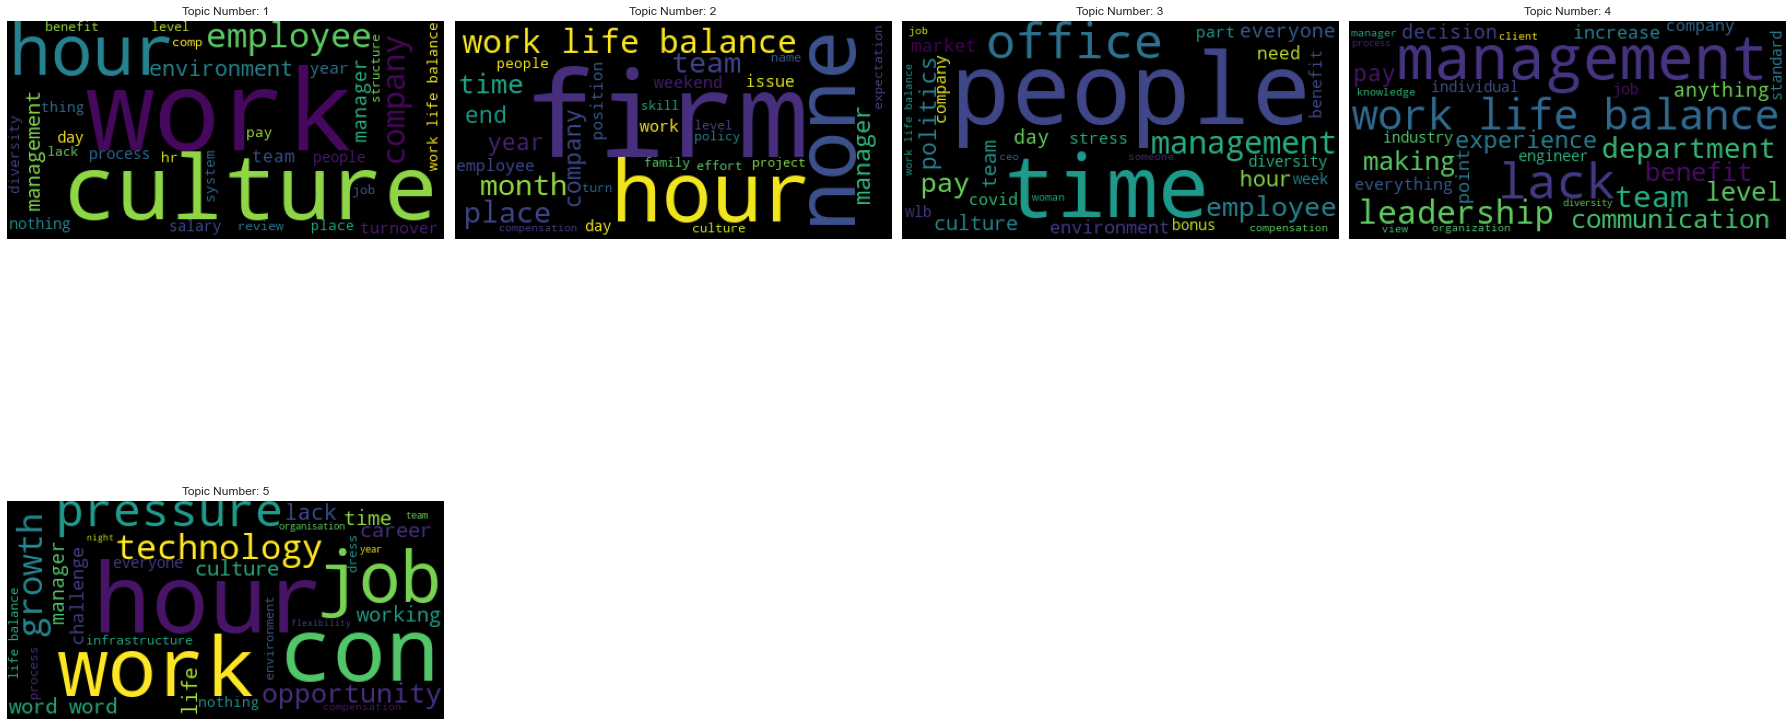

In [99]:
plot_wordclouds_lda(lda_model_cons_low, num_words=30)

In [101]:
# Visualize lda model 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_cons_low, doc_term_matrix_cons_low, id2word_cons_low)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.001705  0.046728       1        1  39.021595
2     -0.106435 -0.041647       2        1  19.216921
1     -0.029514  0.129839       3        1  18.563609
4      0.159947 -0.019363       4        1  14.268315
3     -0.022293 -0.115556       5        1   8.929560, topic_info=           Term       Freq      Total Category  logprob  loglift
80       people  58.000000  58.000000  Default  30.0000  30.0000
21   management  60.000000  60.000000  Default  29.0000  29.0000
151      office  34.000000  34.000000  Default  28.0000  28.0000
135        time  51.000000  51.000000  Default  27.0000  27.0000
76         firm  24.000000  24.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
31      company   2.570132  48.882730   Topic5  -4.8172  -0.5297
52          job   2.249180  26.253066   Topic5  -4.9506  -0.0414
22      manager   1.934060  39.488989   Topic5  -5.1015  -0.6006
122   diversity   1.640446  16.796564   Topic5  -5.2662   0.0896
26      process   1.593519  20.934324   Topic5  -5.2952  -0.1596

[307 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
938       4  0.660120           adapt
780       5  0.690102      adjustment
362       2  0.955746  administration
839       5  0.690103        adoption
16        1  0.298677        anything
...     ...       ...             ...
108       1  0.548429            year
108       2  0.068554            year
108       3  0.274215            year
108       4  0.102831            year
238       1  0.819179            zoom

[434 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

In [140]:
# Note that GSDMM only requires two input variables: the documents as a numpy array and the length of your dictionary/vocabulary.

# initialize GSDMM
gsdmm = MovieGroupProcess(K=15, alpha=0.1, beta=0.3, n_iters=50)
vocab_len = len(id2word_pandemic)
# fit GSDMM model
y = gsdmm.fit(lst_pros_final_pandemic, vocab_len) #total_word_count = len(tokens)

In stage 0: transferred 3761 clusters with 15 clusters populated
In stage 1: transferred 2855 clusters with 15 clusters populated
In stage 2: transferred 1961 clusters with 15 clusters populated
In stage 3: transferred 1377 clusters with 15 clusters populated
In stage 4: transferred 1063 clusters with 15 clusters populated
In stage 5: transferred 861 clusters with 15 clusters populated
In stage 6: transferred 786 clusters with 14 clusters populated
In stage 7: transferred 717 clusters with 13 clusters populated
In stage 8: transferred 710 clusters with 12 clusters populated
In stage 9: transferred 680 clusters with 13 clusters populated
In stage 10: transferred 648 clusters with 12 clusters populated
In stage 11: transferred 624 clusters with 12 clusters populated
In stage 12: transferred 590 clusters with 12 clusters populated
In stage 13: transferred 581 clusters with 12 clusters populated
In stage 14: transferred 582 clusters with 11 clusters populated
In stage 15: transferred 614 c

In [141]:
# number of docs per topic 
doc_count = np.array(gsdmm.cluster_doc_count)
# print('Number of documents per topic :', doc_count)

# sort the indexes by importance 
indexes_sorted = doc_count.argsort()[::-1]
# print(f'Index of docs arranged by importance: {indexes_sorted}')

top_words_gsdmm(gsdmm.cluster_word_distribution, indexes_sorted, 20)

Cluster 7: [('good', 1297), ('great', 1086), ('work', 694), ('people', 628), ('benefit', 507), ('culture', 465), ('pay', 292), ('company', 277), ('environment', 245), ('nice', 241), ('work life balance', 210), ('smart people', 194), ('team', 193), ('place', 187), ('compensation', 149), ('friendly', 143), ('opportunity', 134), ('salary', 112), ('management', 110), ('firm', 105)]
Cluster 6: [('work', 251), ('people', 234), ('great', 225), ('company', 205), ('culture', 204), ('good', 171), ('employee', 152), ('team', 106), ('firm', 98), ('get', 96), ('opportunity', 83), ('benefit', 73), ('environment', 73), ('really', 67), ('well', 66), ('best', 63), ('management', 62), ('place', 61), ('learn', 60), ('strong', 57)]
Cluster 14: [('work', 65), ('team', 48), ('people', 46), ('firm', 45), ('company', 45), ('place', 36), ('employee', 35), ('good', 32), ('time', 31), ('one', 29), ('like', 29), ('great', 28), ('get', 28), ('office', 28), ('benefit', 24), ('year', 24), ('new', 24), ('many', 23), 

In [142]:
# gsdmm.cluster_word_distribution[10].items()

Total plots: 9, Total cols: 4, Total rows: 3


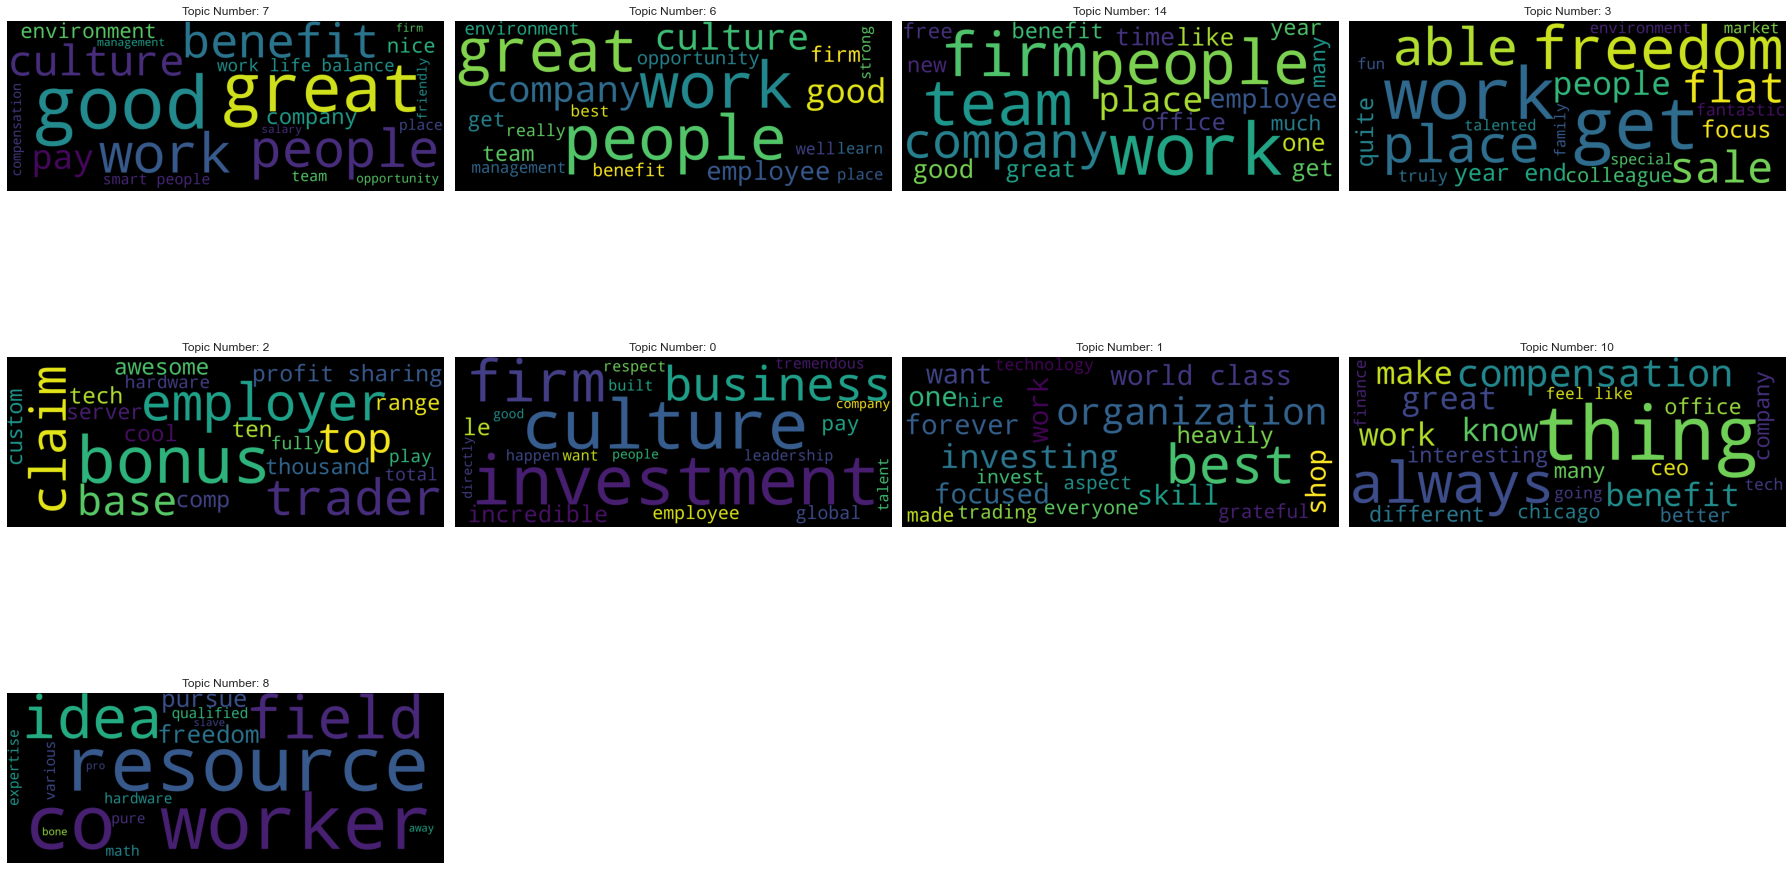

In [143]:
plot_wordclouds(gsdmm.cluster_word_distribution, indexes_sorted)

<a id='combined_column'></a>
## 4. Analyzing Combined Text Column
* Most common words 
* Bigrams 
* LDA Topic Modeling

In [133]:
# get text data from each relevant column dataframe 
# create lists of tokenized lists 

# ALL REVIEWS 
lst_corpus_combined_nouns = df['combined_text_nouns'].map(word_tokenize).values
tokens_combined_nouns = list(itertools.chain(*lst_corpus_combined_nouns))

### Combined Text - Most common words 

In [50]:
freqdist = FreqDist(tokens_combined_nouns)
most_common = freqdist.most_common(25)

df1 = pd.DataFrame(most_common, columns=['word','frequency'])
df1['freq_normalized'] = df1.frequency/len(tokens_combined_nouns)
df1 = df1.drop('frequency', axis=1)
df1 = df1.style.set_caption("Most Common Words (2012-Present)").hide_index()

df1

### Combined Text - Bigrams
* Get bigrams for tokens with all parts of speech 

#### Combined Text - Bigrams - All Reviews

In [35]:
# creat tokenized lists from all words, not just nouns 
lst_corpus_combined = df['combined_text'].map(word_tokenize).values 
tokens_combined = list(itertools.chain(*lst_corpus_combined))

display_bigrams(tokens_combined)

Top Bigrams Based on Raw Frequency: 
(('work', 'life'), 0.004805487263186166)
(('life', 'balance'), 0.004656736152717807)
(('place', 'work'), 0.0045245129434125985)
(('great', 'place'), 0.0034873871454248703)
(('smart', 'people'), 0.002520504927380534)
(('great', 'company'), 0.002367621841621387)
(('long', 'hour'), 0.002264322459351693)
(('great', 'people'), 0.0017065057950953453)
(('great', 'benefit'), 0.00166105406689668)
(('work', 'environment'), 0.0016362622151519534)

Top Bigrams Based on PMI: 
('silicon', 'valley')
('bulge', 'bracket')
('hong', 'kong')
('cherry', 'creek')
('stepping', 'stone')
('sink', 'swim')
('newport', 'beach')
('kool', 'aid')
('town', 'hall')
('inner', 'circle')


#### Combined Text - Bigrams - Pandemic

In [106]:
# creat tokenized lists from all words, not just nouns 
lst_corpus_headlines_pandemic = df_pandemic['headline_cleaned'].map(word_tokenize).values
tokens_headlines_pandemic = list(itertools.chain(*lst_corpus_headlines_pandemic))

display_bigrams(tokens_headlines_pandemic)

Top Bigrams Based on Raw Frequency: 
(('place', 'work'), 0.03776028693832818)
(('great', 'place'), 0.02959051509415164)
(('great', 'company'), 0.021520374613928465)
(('good', 'place'), 0.013350602769751918)
(('work', 'great'), 0.012852445949985055)
(('good', 'company'), 0.011557238218591212)
(('company', 'great'), 0.009365348211617016)
(('work', 'good'), 0.008667928663943409)
(('company', 'work'), 0.007372720932549566)
(('great', 'culture'), 0.0062767759290624685)

Top Bigrams Based on PMI: 
('fast', 'paced')
('long', 'hour')
('asset', 'management')
('life', 'balance')
('start', 'career')
('smart', 'people')
('working', 'environment')
('learning', 'experience')
('work', 'life')
('toxic', 'culture')


Interestingly, the results of the PMI finder related to office and location disappear. Presumably during the pandemic these were less important benefits. Instead the focus is on culture, inclusion, retention, and health. 

### Combined Text - LDA Topic Modeling

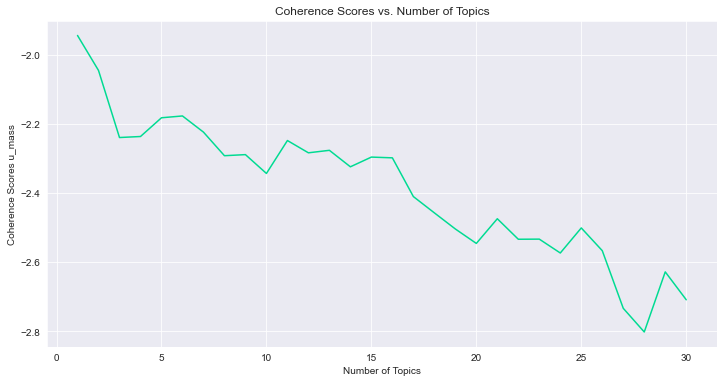

num_topics  coherence_score_u_mass  perplexity_score
0            1               -1.944159         -6.563539
1            2               -2.045271         -6.619978
5            6               -2.176901         -6.776938
4            5               -2.182157         -6.746500
6            7               -2.223624         -6.793124
3            4               -2.236316         -6.710170
2            3               -2.239266         -6.679394
10          11               -2.247944         -6.863389
12          13               -2.276254         -6.894523
11          12               -2.283458         -6.880154
8            9               -2.288704         -6.832579
7            8               -2.291827         -6.812283
14          15               -2.295834         -6.928584
15          16               -2.297984         -6.940048
13          14               -2.323920         -6.905761
9           10               -2.343142         -6.849961
16          17               -2.409965         -6.949616
17          18               -2.457085         -6.956829
20          21               -2.474095         -6.989032
24          25               -2.500684         -7.039629
18          19               -2.503702         -6.967763
22          23               -2.533043         -7.020212
21          22               -2.533402         -7.003723
19          20               -2.545450         -6.977469
25          26               -2.566462         -7.043790
23          24               -2.573140         -7.025675
28          29               -2.627696         -7.076239
29          30               -2.708388         -7.093122
26          27               -2.733090         -7.057243
27          28               -2.801504         -7.073464

In [134]:
lst_combined_final = get_bigrams_trigrams(lst_corpus_combined_nouns)
id2word_combined, doc_term_matrix_combined = get_id2word_doc_matrix(lst_combined_final)

coherence_pros_df = find_optimal_topics(doc_term_matrix_combined, id2word_combined, lst_combined_final, min_topics=1, max_topics=30, coherence='u_mass', display=True)
coherence_pros_df

In [135]:
lda_model_combined = LdaModel(corpus=doc_term_matrix_combined, id2word=id2word_combined, num_topics=5, random_state=123, passes=25)
lda_model_combined.print_topics(num_words=25)

[(0,
  '0.085*"people" + 0.064*"place" + 0.054*"culture" + 0.050*"work" + 0.043*"hour" + 0.027*"environment" + 0.024*"pay" + 0.020*"benefit" + 0.019*"experience" + 0.019*"opportunity" + 0.019*"work life balance" + 0.017*"company" + 0.017*"firm" + 0.016*"time" + 0.015*"none" + 0.014*"team" + 0.011*"analyst" + 0.010*"job" + 0.010*"growth" + 0.009*"career" + 0.009*"deal" + 0.009*"associate" + 0.008*"work environment" + 0.008*"balance" + 0.008*"compensation"'),
 (1,
  '0.034*"management" + 0.029*"people" + 0.024*"manager" + 0.023*"benefit" + 0.022*"employee" + 0.020*"company" + 0.018*"job" + 0.015*"time" + 0.015*"team" + 0.014*"pay" + 0.013*"year" + 0.013*"work" + 0.011*"office" + 0.010*"staff" + 0.010*"department" + 0.008*"culture" + 0.007*"work life balance" + 0.007*"hour" + 0.007*"day" + 0.007*"level" + 0.007*"bonus" + 0.007*"way" + 0.006*"position" + 0.006*"place" + 0.006*"opportunity"'),
 (2,
  '0.117*"company" + 0.047*"benefit" + 0.032*"culture" + 0.027*"salary" + 0.024*"environment"

Total plots: 5, Total cols: 4, Total rows: 2


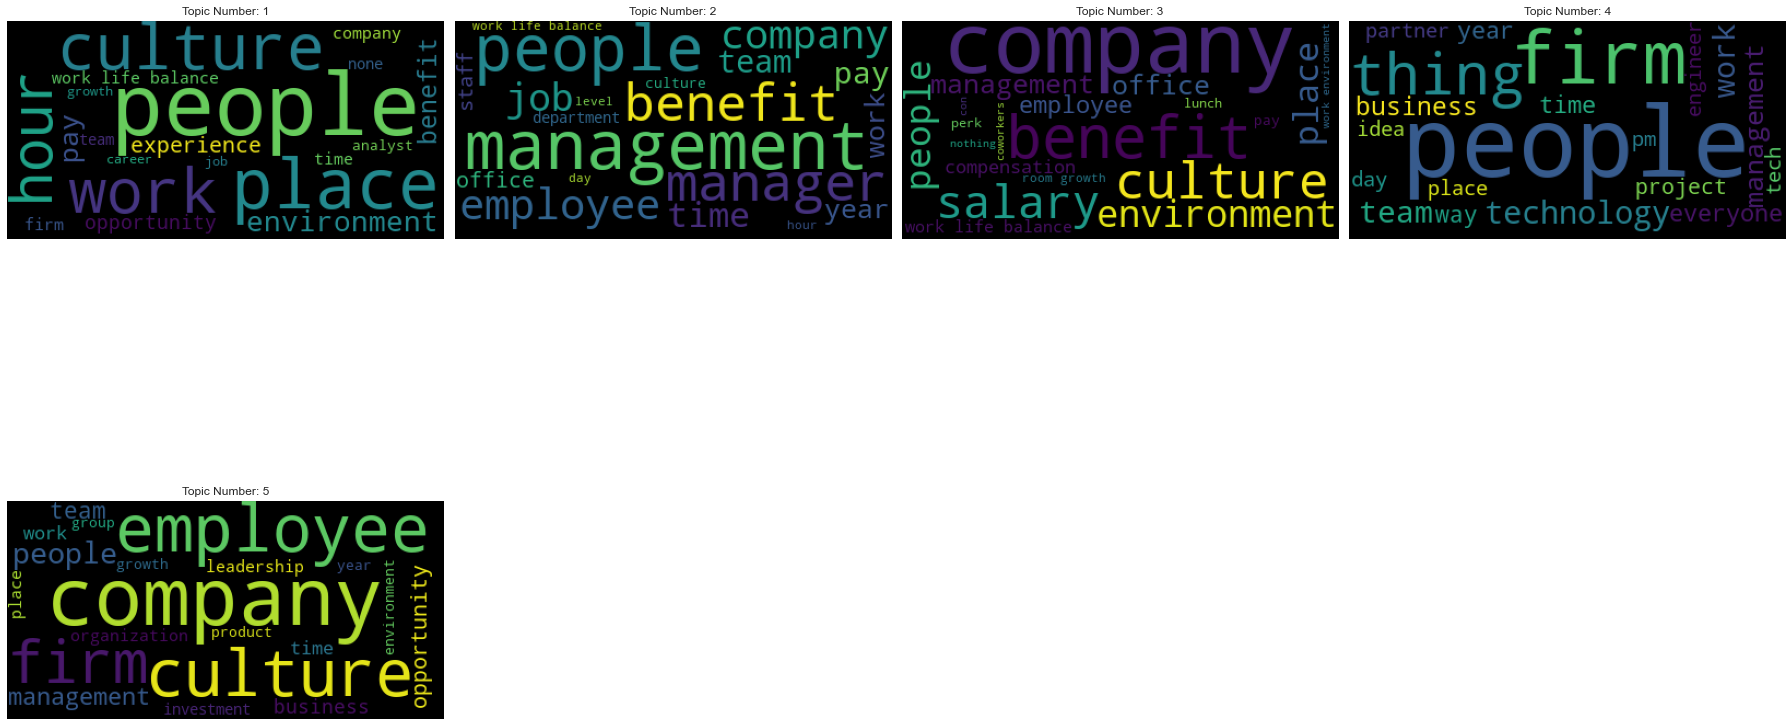

In [158]:
plot_wordclouds_lda(lda_model_combined)

In [136]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_combined, doc_term_matrix_combined, id2word_combined)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.010976  0.061288       1        1  28.263202
4      0.049591 -0.018920       2        1  27.749331
0     -0.087330 -0.201623       3        1  17.988882
3      0.225253  0.033673       4        1  15.935761
2     -0.198491  0.125583       5        1  10.062823, topic_info=            Term         Freq        Total Category  logprob  loglift
12       company  3436.000000  3436.000000  Default  30.0000  30.0000
9        benefit  1646.000000  1646.000000  Default  29.0000  29.0000
14       culture  2447.000000  2447.000000  Default  28.0000  28.0000
56         place  2174.000000  2174.000000  Default  27.0000  27.0000
210         hour  1114.000000  1114.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
212       change    64.664978   277.884107   Topic5  -5.1537   0.8383
71     structure    63.603823   290.696646   Topic5  -5.1703   0.7767
352  expectation    49.931721   164.810786   Topic5  -5.4123   1.1022
27         thing    53.077131   598.199886   Topic5  -5.3512  -0.1259
6           team    51.907763  1623.407658   Topic5  -5.3735  -1.1465

[356 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
325       1  0.990843   accounting
1647      5  0.956600  achievement
1450      2  0.926091     activity
1450      4  0.077174     activity
830       1  0.980089        admin
...     ...       ...          ...
6049      5  0.953011           wp
85        1  0.504413         year
85        2  0.296643         year
85        4  0.176544         year
85        5  0.021618         year

[506 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

<a id='headlines_column'></a>
## 5. Analyzing Headlines Column
* Most common words 
* Bigrams 

In [159]:
# # PANDEMIC 
lst_corpus_headlines_nouns = df_pandemic['headline_cleaned_nouns'].map(word_tokenize).values
tokens_headlines_nouns = list(itertools.chain(*lst_corpus_headlines_nouns))

In [160]:
freqdist = FreqDist(tokens_headlines_nouns)
most_common = freqdist.most_common(25)

df1 = pd.DataFrame(most_common, columns=['word','frequency'])
df1['freq_normalized'] = df1.frequency/len(tokens_headlines_nouns)
df1 = df1.drop('frequency', axis=1)
df1 = df1.style.set_caption("Most Common Words (2020-Present)").hide_index()

df1

In [161]:
lst_corpus_headlines = df_pandemic['headline_cleaned'].map(word_tokenize).values
tokens_headlines = list(itertools.chain(*lst_corpus_headlines))
display_bigrams(tokens_headlines)

Top Bigrams Based on Raw Frequency: 
(('place', 'work'), 0.03776028693832818)
(('great', 'place'), 0.02959051509415164)
(('great', 'company'), 0.021520374613928465)
(('good', 'place'), 0.013350602769751918)
(('work', 'great'), 0.012852445949985055)
(('good', 'company'), 0.011557238218591212)
(('company', 'great'), 0.009365348211617016)
(('work', 'good'), 0.008667928663943409)
(('company', 'work'), 0.007372720932549566)
(('great', 'culture'), 0.0062767759290624685)

Top Bigrams Based on PMI: 
('fast', 'paced')
('long', 'hour')
('asset', 'management')
('life', 'balance')
('start', 'career')
('smart', 'people')
('working', 'environment')
('learning', 'experience')
('work', 'life')
('toxic', 'culture')


# IV. Conclusions/Next Steps

* Closer look at individual firms: As noted above, some firms are trending up and down. Why is this? Is it related to performance or any other identifiable factors? 
* Other industries: Expand beyond the alternative assets space, and look at other industries such as tech. 
* Get predictive: Ratings can be predicted through text data using word embedding, neural networks, etc..